# Demographic-Aware QoE Prediction Using Data Augmentation

## Overview
This notebook implements a novel demographic augmentation technique to enhance QoE prediction models for adaptive video streaming. The methodology involves creating synthetic samples based on user demographic profiles to address dataset limitations.

## Research Contributions
1. **Demographic Profiling**: Six distinct user profiles with varying QoE sensitivities
2. **Augmentation Algorithm**: Novel MOS adjustment based on demographic characteristics
3. **Performance Enhancement**: Improved prediction accuracy through augmented training data

## Methodology
- **Input**: Base QoE dataset (450 streaming sessions)
- **Process**: 6× augmentation with demographic-specific transformations
- **Output**: Enhanced dataset (2,700 samples) for improved model generalization


In [41]:
# Import required libraries
import pandas as pd
import numpy as np
import os
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Define paths
base_path = "data"
os.makedirs(base_path, exist_ok=True)

# Load the combined dataset
df = pd.read_csv(os.path.join(base_path, "combined_dataset.csv"))

print("="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Dataset shape: {df.shape}")
print(f"MOS range: {df['mos'].min():.2f} - {df['mos'].max():.2f}")
print(f"MOS mean: {df['mos'].mean():.2f}")
print(f"MOS std: {df['mos'].std():.2f}")
print("="*70)


DATASET INFORMATION
Dataset shape: (450, 70)
MOS range: 11.68 - 96.63
MOS mean: 60.87
MOS std: 15.51


# 1. Demographic Profile Definition

## 1.1 User Demographics and QoE Sensitivity

This section defines six distinct user demographic profiles based on varying QoE perception characteristics. Each profile has unique sensitivity weights for quality factors that influence their subjective experience.

### Demographic Profiles:
1. **Casual Viewer**: High rebuffering sensitivity, moderate quality expectations
2. **Quality Enthusiast**: Extremely quality-conscious, notices compression artifacts
3. **Mobile User**: Network-aware, lower expectations due to device constraints
4. **Gamer/Sports Fan**: Requires smooth playback, cannot tolerate interruptions
5. **Elderly User**: Less discerning of quality nuances, confused by technical issues
6. **Professional/Critical**: Professional use case, highest standards for quality


In [42]:
# Define demographic profiles with their QoE sensitivity factors
demographic_profiles = {
    'casual_viewer': {
        'rebuffering_sensitivity': 2.0,      # Very annoyed by stalls
        'quality_sensitivity': 0.6,          # Less sensitive to quality drops
        'bitrate_sensitivity': 0.5,          # Don't care much about bitrate
        'consistency_preference': 0.7,       # Prefer consistent quality
        'mos_adjustment': lambda base_mos, factors: base_mos * (1 - 0.15 * factors['rebuffering_impact'] + 0.05 * factors['quality_boost'])
    },
    'quality_enthusiast': {
        'rebuffering_sensitivity': 1.2,
        'quality_sensitivity': 2.5,          # Highly sensitive to VMAF, SSIM
        'bitrate_sensitivity': 2.0,          # Want high bitrates
        'consistency_preference': 1.5,
        'mos_adjustment': lambda base_mos, factors: base_mos * (1 + 0.20 * factors['quality_boost'] - 0.25 * factors['quality_variance'] - 0.08 * factors['rebuffering_impact'])
    },
    'mobile_user': {
        'rebuffering_sensitivity': 2.5,      # Cellular network issues are frustrating
        'quality_sensitivity': 0.4,          # Small screen, less noticeable
        'bitrate_sensitivity': 0.3,          # Data concerns, lower expectations
        'consistency_preference': 1.8,       # Network fluctuations matter
        'mos_adjustment': lambda base_mos, factors: base_mos * (1 - 0.20 * factors['rebuffering_impact'] - 0.15 * factors['quality_variance'] + 0.10)
    },
    'gamer_sports': {
        'rebuffering_sensitivity': 2.8,      # Cannot miss action moments
        'quality_sensitivity': 1.5,
        'bitrate_sensitivity': 1.2,
        'consistency_preference': 2.0,       # Smooth playback is critical
        'mos_adjustment': lambda base_mos, factors: base_mos * (1 - 0.25 * factors['rebuffering_impact'] - 0.20 * factors['quality_variance'] + 0.08 * factors['smoothness'])
    },
    'elderly_user': {
        'rebuffering_sensitivity': 2.2,      # Confused by technical issues
        'quality_sensitivity': 0.3,          # Less discerning of quality nuances
        'bitrate_sensitivity': 0.2,
        'consistency_preference': 1.0,
        'mos_adjustment': lambda base_mos, factors: base_mos * (1 - 0.18 * factors['rebuffering_impact'] + 0.12 * factors['simplicity'])
    },
    'professional_critical': {
        'rebuffering_sensitivity': 1.8,
        'quality_sensitivity': 3.0,          # Extremely sensitive to artifacts
        'bitrate_sensitivity': 2.5,
        'consistency_preference': 2.2,
        'mos_adjustment': lambda base_mos, factors: base_mos * (1 + 0.15 * factors['quality_boost'] - 0.35 * factors['quality_variance'] - 0.12 * factors['rebuffering_impact'] - 0.10 * factors['compression_artifacts'])
    }
}

print("Defined demographic profiles:")
for profile in demographic_profiles.keys():
    print(f"  - {profile}")

Defined demographic profiles:
  - casual_viewer
  - quality_enthusiast
  - mobile_user
  - gamer_sports
  - elderly_user
  - professional_critical


# 2. Impact Factor Computation

## 2.1 Streaming Metrics to Impact Factors

This section computes normalized impact factors from raw streaming metrics. These factors are used in the demographic-specific MOS adjustment formulas.

### Impact Factors:
- **Rebuffering Impact**: Normalized stall duration (0-1 scale)
- **Quality Boost**: Combined VMAF and SSIM normalized scores
- **Quality Variance**: Coefficient of variation for VMAF and bitrate
- **Smoothness**: Inverse of quality variance (1 = perfectly smooth)
- **Compression Artifacts**: QP-based compression level (0-1 scale)


In [43]:
def calculate_impact_factors(row):
    """
    Calculate various impact factors from streaming metrics
    """
    factors = {}

    # Rebuffering impact (normalized)
    factors['rebuffering_impact'] = min(row['rebuffering_duration_mean'] / 2.0, 1.0)

    # Quality boost (based on VMAF, SSIM)
    vmaf_normalized = row['vmaf_mean'] / 100.0
    ssim_normalized = row['ssim_mean']
    factors['quality_boost'] = (vmaf_normalized + ssim_normalized) / 2.0

    # Quality variance (inconsistency penalty)
    vmaf_cv = row['vmaf_std'] / (row['vmaf_mean'] + 1e-5)  # Coefficient of variation
    bitrate_cv = row['video_bitrate_std'] / (row['video_bitrate_mean'] + 1e-5)
    factors['quality_variance'] = (vmaf_cv + bitrate_cv) / 2.0

    # Smoothness (low variance in metrics)
    factors['smoothness'] = 1.0 - min(factors['quality_variance'], 1.0)

    # Simplicity bonus (for elderly - fewer quality switches)
    factors['simplicity'] = factors['smoothness']

    # Compression artifacts (based on QP - higher QP = more compression)
    qp_normalized = min(row['qp_mean'] / 51.0, 1.0)  # QP ranges 0-51 in H.264
    factors['compression_artifacts'] = qp_normalized

    return factors

# Test on first row
test_factors = calculate_impact_factors(df.iloc[0])
print("Sample impact factors for first session:")
for key, val in test_factors.items():
    print(f"  {key}: {val:.4f}")

Sample impact factors for first session:
  rebuffering_impact: 0.4033
  quality_boost: 0.4896
  quality_variance: 0.5035
  smoothness: 0.4965
  simplicity: 0.4965
  compression_artifacts: 0.5468


# 3. Demographic Augmentation Algorithm

## 3.1 Dataset Augmentation Process

This section implements the core augmentation algorithm that generates demographic-specific MOS variations for each streaming session.

### Algorithm Steps:
1. For each original streaming session (450 samples)
2. Calculate impact factors from streaming metrics
3. For each of 6 demographic profiles:
   - Apply demographic-specific MOS adjustment formula
   - Add individual variation noise (σ = 2.0)
   - Clip to valid MOS range [0, 100]
4. Generate augmented sample with demographic label

**Result**: 450 × 6 = 2,700 augmented samples


In [44]:
def augment_with_demographics(df, demographic_profiles):
    """
    Create augmented dataset with demographic-adjusted MOS scores
    """
    augmented_data = []

    for idx, row in df.iterrows():
        # Calculate impact factors
        factors = calculate_impact_factors(row)
        base_mos = row['mos']

        # Generate samples for each demographic
        for demo_name, demo_profile in demographic_profiles.items():
            # Adjust MOS based on demographic profile
            adjusted_mos = demo_profile['mos_adjustment'](base_mos, factors)

            # Add some demographic-specific noise to simulate individual differences
            noise_std = 2.0  # Standard deviation for individual variation
            noisy_mos = adjusted_mos + np.random.normal(0, noise_std)

            # Clip to valid MOS range (typically 0-100 in this dataset)
            final_mos = np.clip(noisy_mos, 0, 100)

            # Create augmented row
            aug_row = row.copy()
            aug_row['mos'] = final_mos
            aug_row['demographic'] = demo_name
            aug_row['original_mos'] = base_mos
            aug_row['mos_adjustment'] = final_mos - base_mos

            augmented_data.append(aug_row)

    return pd.DataFrame(augmented_data)

# Generate augmented dataset
print("Generating demographic-augmented dataset...")
df_augmented = augment_with_demographics(df, demographic_profiles)

print(f"\nAugmented dataset shape: {df_augmented.shape}")
print(f"Original dataset: {len(df)} samples")
print(f"Augmented dataset: {len(df_augmented)} samples")
print(f"Augmentation factor: {len(df_augmented) / len(df):.1f}x")
print(f"\nDemographic distribution:")
print(df_augmented['demographic'].value_counts())

Generating demographic-augmented dataset...

Augmented dataset shape: (2700, 73)
Original dataset: 450 samples
Augmented dataset: 2700 samples
Augmentation factor: 6.0x

Demographic distribution:
demographic
casual_viewer            450
quality_enthusiast       450
mobile_user              450
gamer_sports             450
elderly_user             450
professional_critical    450
Name: count, dtype: int64

Augmented dataset shape: (2700, 73)
Original dataset: 450 samples
Augmented dataset: 2700 samples
Augmentation factor: 6.0x

Demographic distribution:
demographic
casual_viewer            450
quality_enthusiast       450
mobile_user              450
gamer_sports             450
elderly_user             450
professional_critical    450
Name: count, dtype: int64


# 4. Augmented Dataset Analysis

## 4.1 MOS Distribution Analysis by Demographic

Visualization and statistical analysis of MOS score distributions across different demographic profiles to validate the augmentation process.


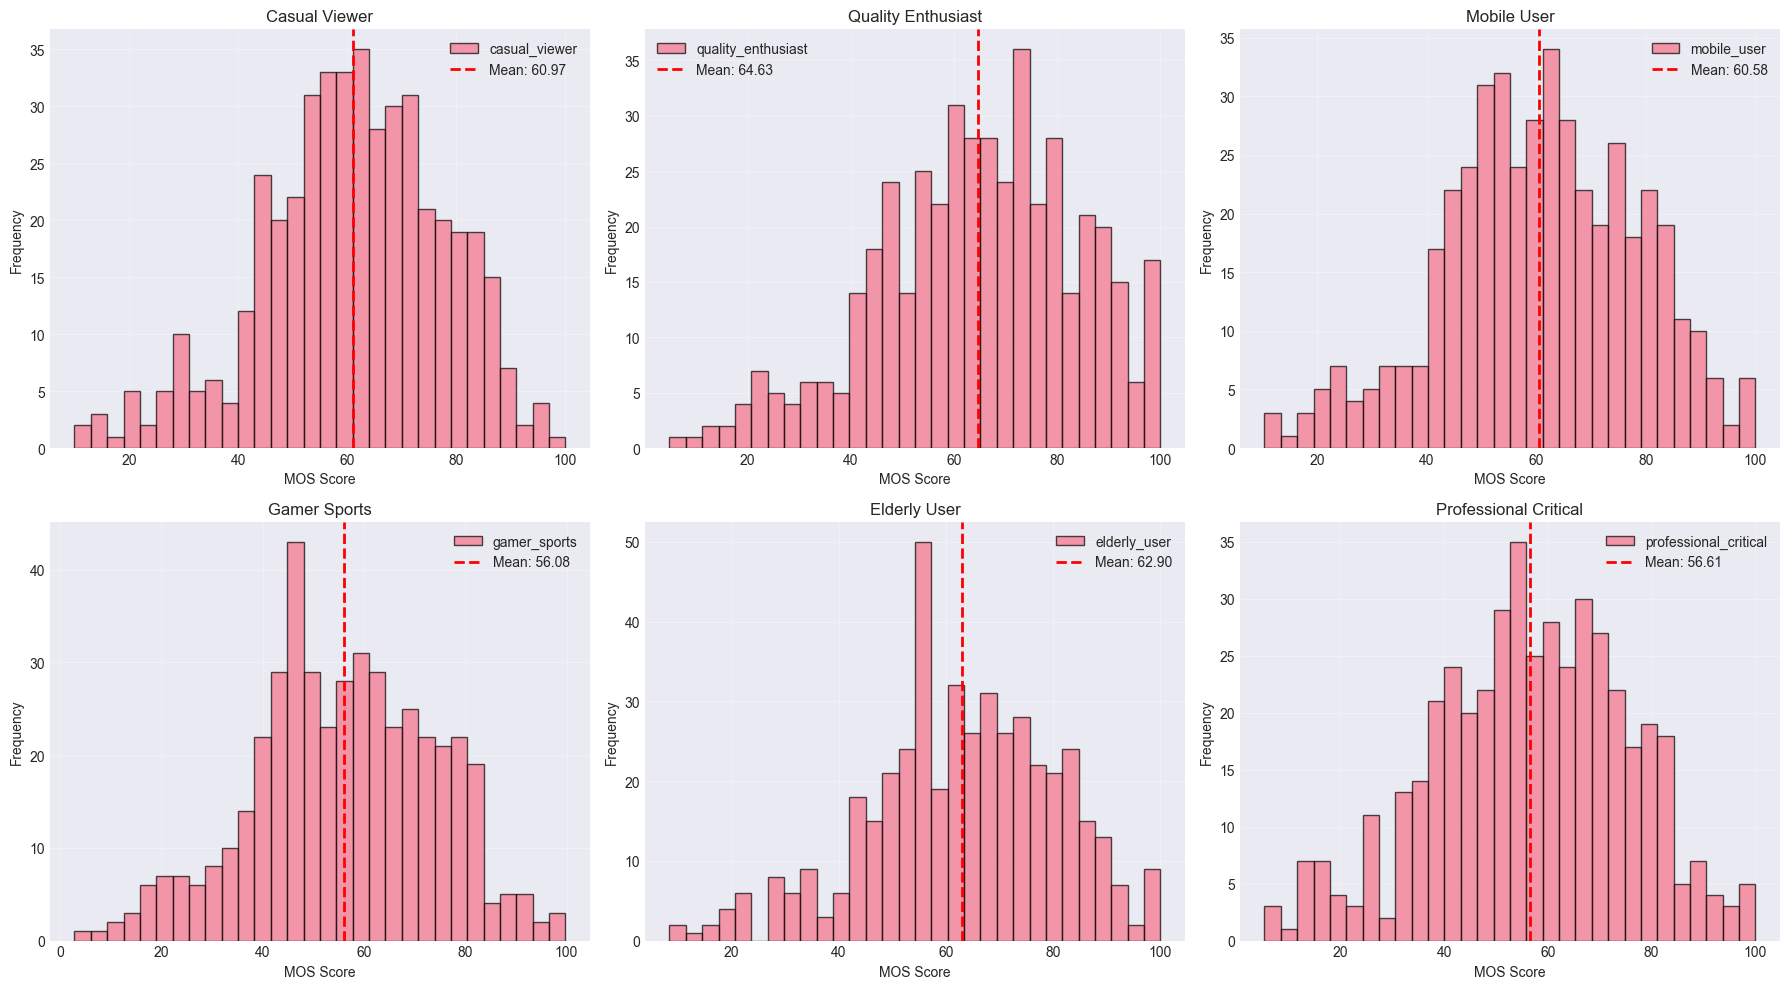


=== MOS Statistics by Demographic ===
                        mean    std    min     max  count
demographic                                              
casual_viewer          60.97  16.71   9.99  100.00    450
elderly_user           62.90  17.73   8.44  100.00    450
gamer_sports           56.08  18.00   2.83   99.78    450
mobile_user            60.58  17.82  10.39  100.00    450
professional_critical  56.61  18.94   5.39  100.00    450
quality_enthusiast     64.63  19.54   4.83  100.00    450


In [45]:
# Compare MOS distributions across demographics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (demo_name, demo_profile) in enumerate(demographic_profiles.items()):
    demo_data = df_augmented[df_augmented['demographic'] == demo_name]

    axes[idx].hist(demo_data['mos'], bins=30, alpha=0.7, edgecolor='black', label=demo_name)
    axes[idx].axvline(demo_data['mos'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {demo_data["mos"].mean():.2f}')
    axes[idx].set_xlabel('MOS Score')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'{demo_name.replace("_", " ").title()}')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'demographic_mos_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

# Statistical summary by demographic
print("\n=== MOS Statistics by Demographic ===")
demo_stats = df_augmented.groupby('demographic')['mos'].agg(['mean', 'std', 'min', 'max', 'count'])
print(demo_stats.round(2))

# 4.2 MOS Adjustment Visualization

Comparative analysis of original vs demographic-adjusted MOS scores using box plots to show the spread and central tendencies across demographics.


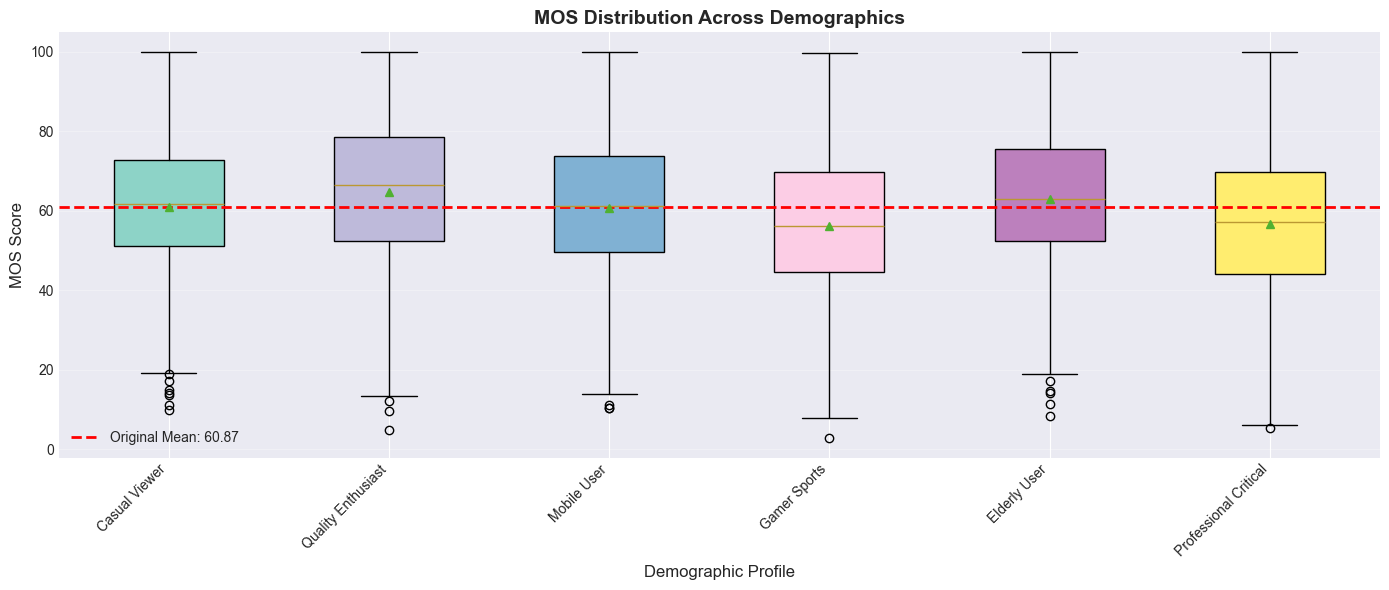

In [46]:
# Box plot comparing original vs demographic-adjusted MOS
fig, ax = plt.subplots(figsize=(14, 6))

# Prepare data for box plot
demo_order = list(demographic_profiles.keys())
data_to_plot = [df_augmented[df_augmented['demographic'] == demo]['mos'] for demo in demo_order]

bp = ax.boxplot(data_to_plot, labels=[d.replace('_', ' ').title() for d in demo_order],
                patch_artist=True, showmeans=True)

# Color the boxes
colors = plt.cm.Set3(np.linspace(0, 1, len(demo_order)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Add original MOS mean as reference line
ax.axhline(df['mos'].mean(), color='red', linestyle='--', linewidth=2, label=f'Original Mean: {df["mos"].mean():.2f}')

ax.set_ylabel('MOS Score', fontsize=12)
ax.set_xlabel('Demographic Profile', fontsize=12)
ax.set_title('MOS Distribution Across Demographics', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'demographic_mos_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# 5. Feature-MOS Correlation Analysis

## 5.1 Demographic-Specific Correlation Patterns

Analysis of how streaming metrics correlate with MOS scores across different demographic profiles. This validates that different demographics exhibit distinct sensitivity patterns.


=== Correlation Analysis per Demographic ===

Casual Viewer:
rebuffering_duration_mean   -0.433
vmaf_mean                    0.620
ssim_mean                    0.345
video_bitrate_mean           0.386
vmaf_std                    -0.250
video_bitrate_std            0.077
Name: mos, dtype: float64

Quality Enthusiast:
rebuffering_duration_mean   -0.309
vmaf_mean                    0.713
ssim_mean                    0.385
video_bitrate_mean           0.475
vmaf_std                    -0.423
video_bitrate_std            0.061
Name: mos, dtype: float64

Mobile User:
rebuffering_duration_mean   -0.437
vmaf_mean                    0.612
ssim_mean                    0.324
video_bitrate_mean           0.376
vmaf_std                    -0.322
video_bitrate_std            0.008
Name: mos, dtype: float64

Gamer Sports:
rebuffering_duration_mean   -0.437
vmaf_mean                    0.620
ssim_mean                    0.327
video_bitrate_mean           0.388
vmaf_std                    -0.383
video_

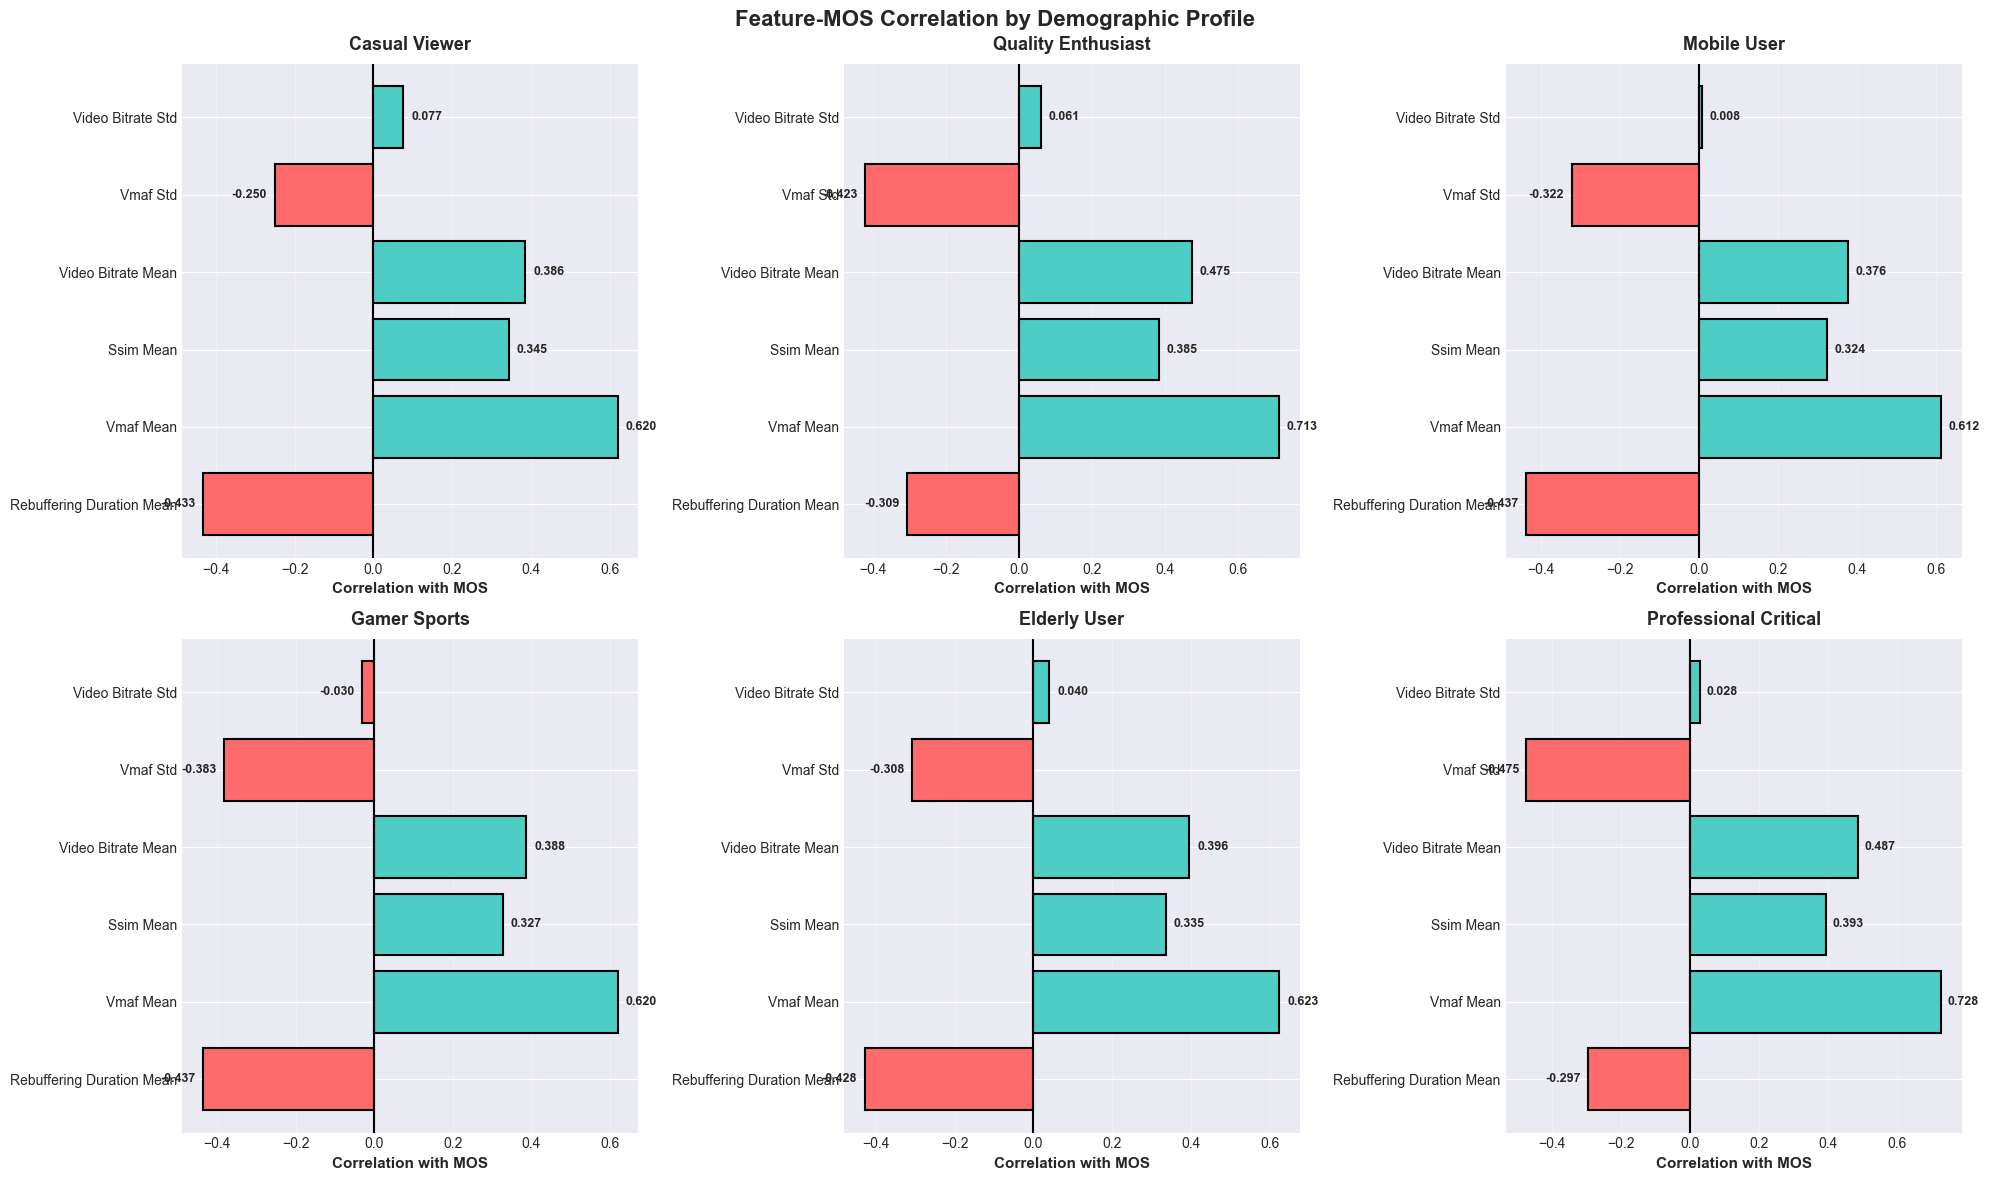

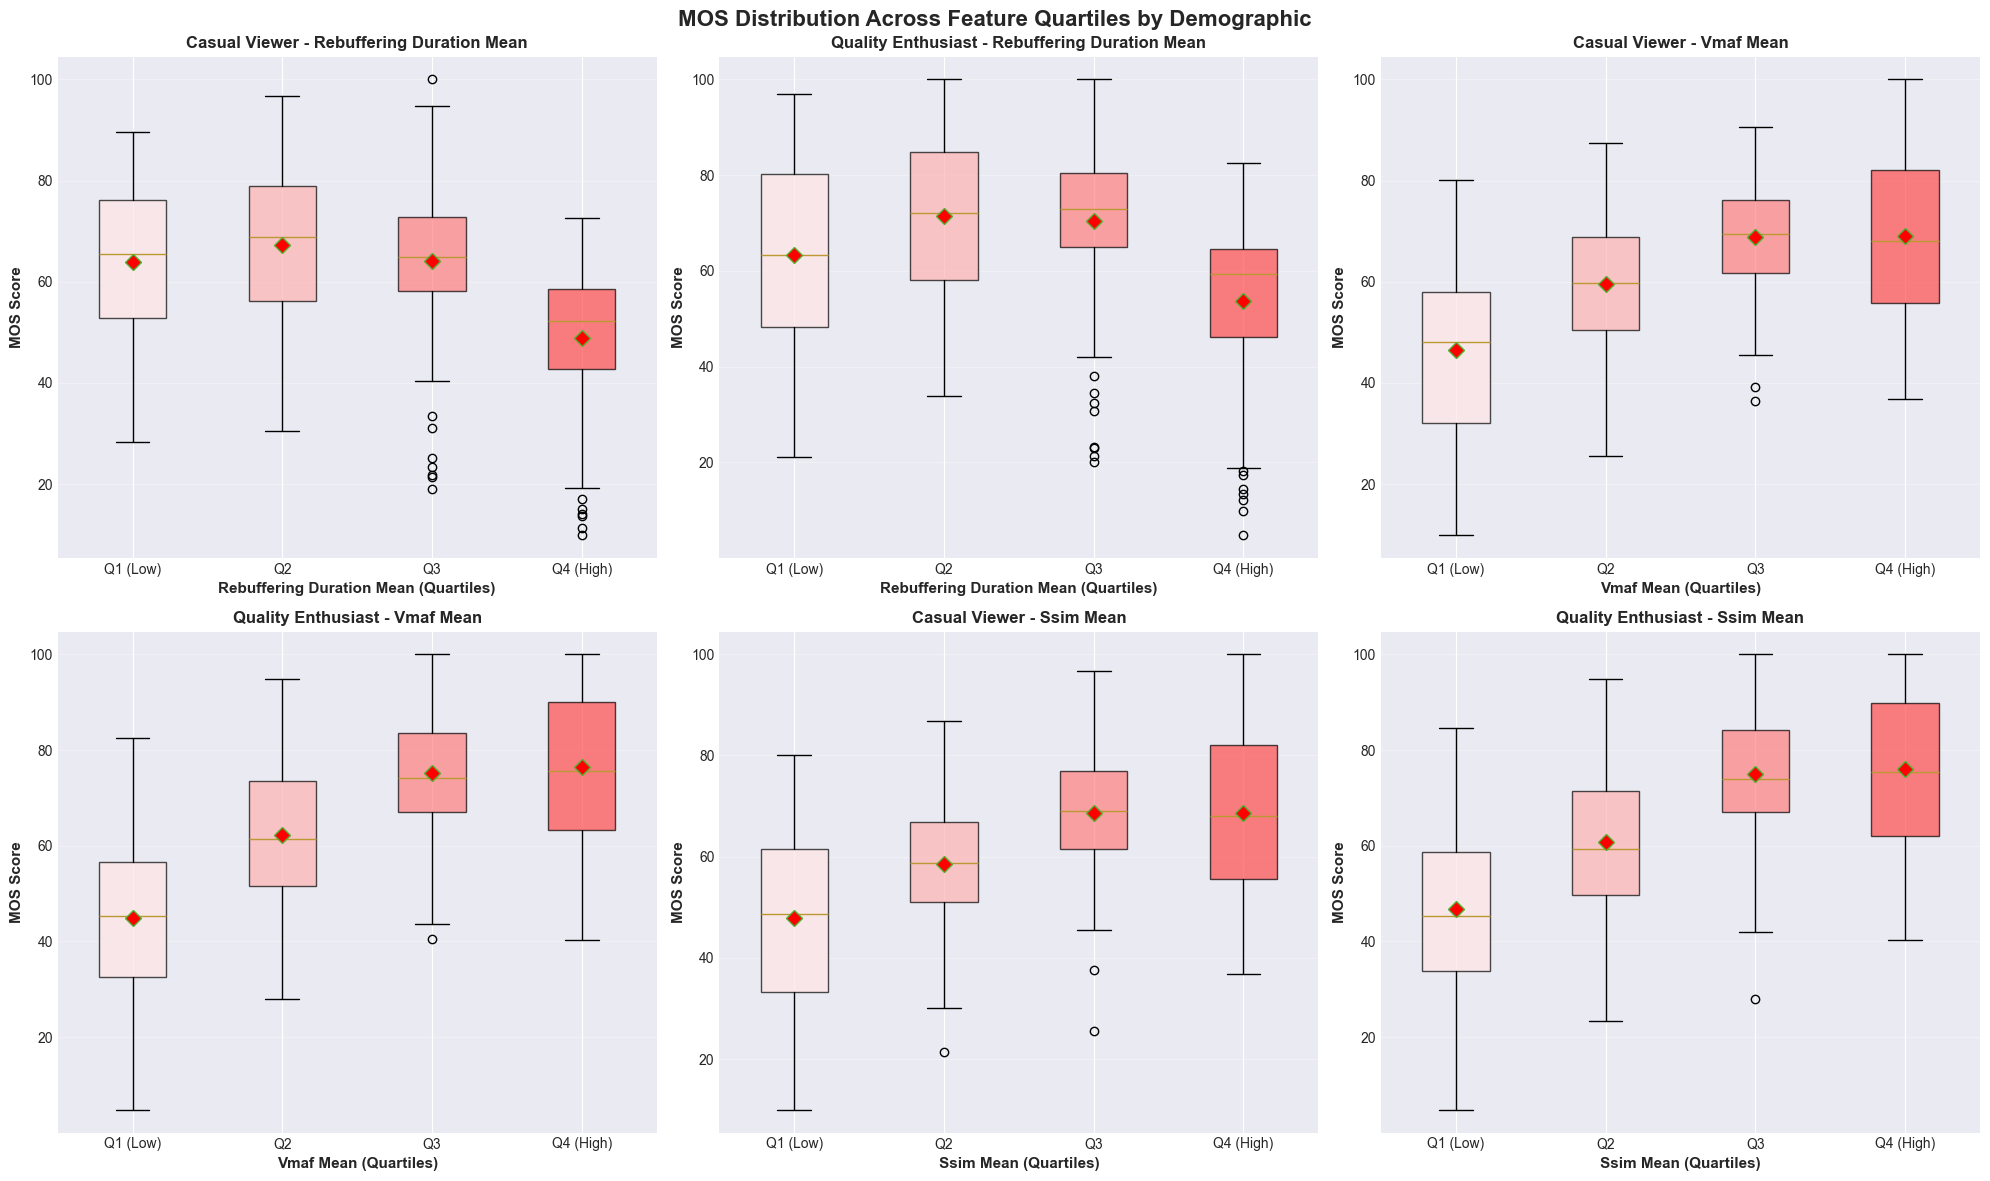

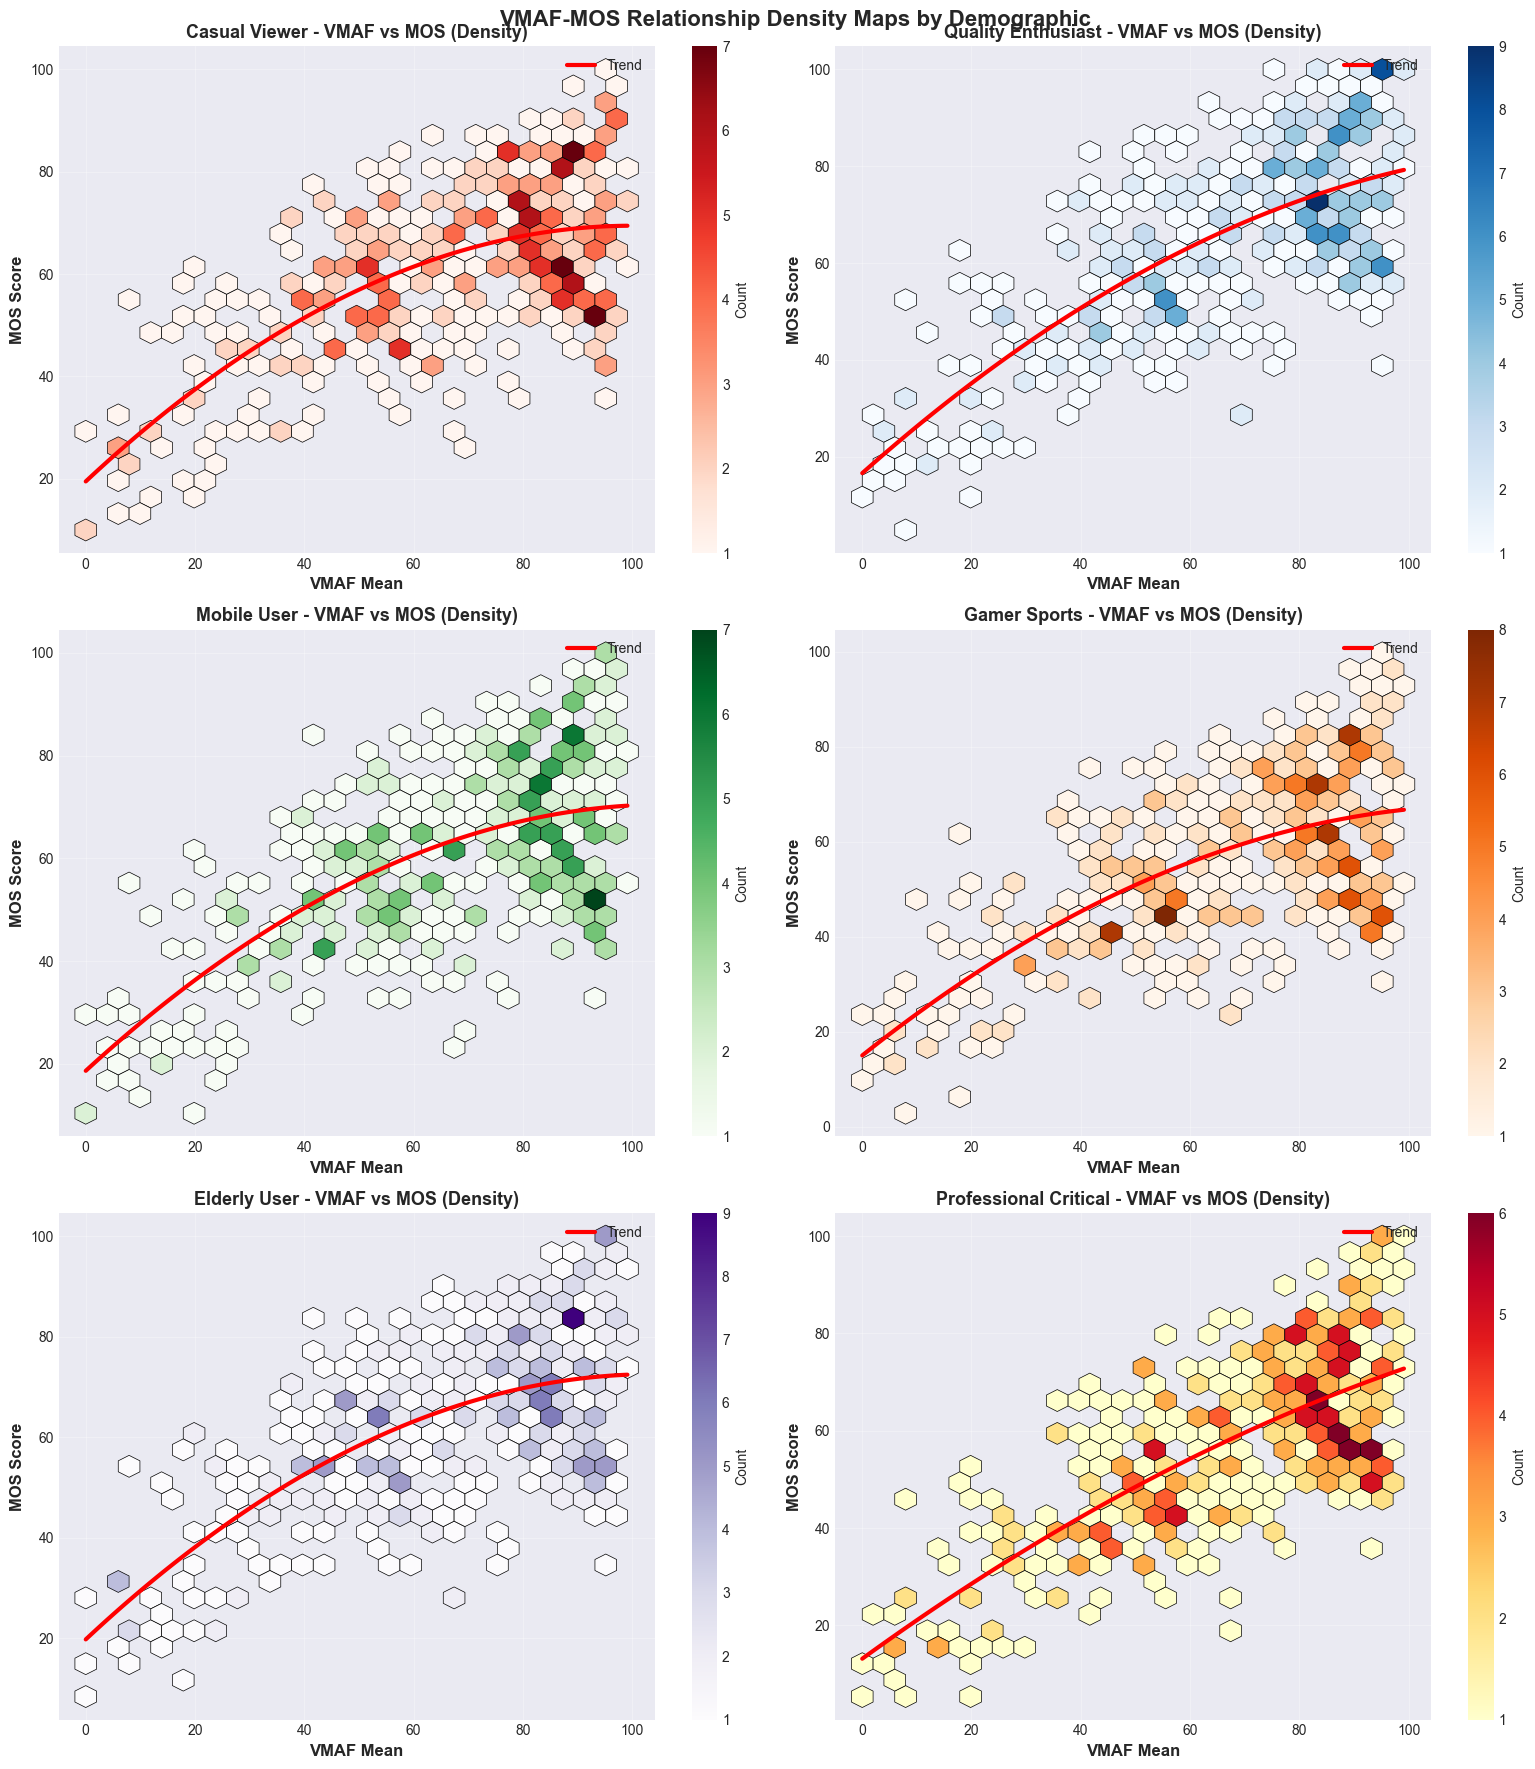

In [47]:
# Key features to analyze
key_features = ['rebuffering_duration_mean', 'vmaf_mean', 'ssim_mean',
                'video_bitrate_mean', 'vmaf_std', 'video_bitrate_std']

# APPROACH 1: Correlation Heatmap per Demographic
print("=== Correlation Analysis per Demographic ===\n")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (demo_name, demo_profile) in enumerate(demographic_profiles.items()):
    demo_data = df_augmented[df_augmented['demographic'] == demo_name]

    # Calculate correlation with MOS for key features
    feature_data = demo_data[key_features + ['mos']]
    corr_matrix = feature_data.corr()['mos'].drop('mos')

    # Create bar plot of correlations
    ax = axes[idx]
    colors_bar = ['#FF6B6B' if x < 0 else '#4ECDC4' for x in corr_matrix.values]
    bars = ax.barh(range(len(corr_matrix)), corr_matrix.values, color=colors_bar, edgecolor='black', linewidth=1.5)
    ax.set_yticks(range(len(corr_matrix)))
    ax.set_yticklabels([f.replace('_', ' ').title() for f in corr_matrix.index], fontsize=10)
    ax.set_xlabel('Correlation with MOS', fontsize=11, fontweight='bold')
    ax.set_title(f'{demo_name.replace("_", " ").title()}', fontsize=13, fontweight='bold', pad=10)
    ax.axvline(0, color='black', linewidth=1.5, linestyle='-')
    ax.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, corr_matrix.values)):
        ax.text(val + 0.02 if val > 0 else val - 0.02, i, f'{val:.3f}',
               va='center', ha='left' if val > 0 else 'right', fontsize=9, fontweight='bold')

    print(f"{demo_name.replace('_', ' ').title()}:")
    print(corr_matrix.round(3))
    print()

plt.suptitle('Feature-MOS Correlation by Demographic Profile', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'demographic_correlation_bars.png'), dpi=300, bbox_inches='tight')
plt.show()

# APPROACH 2: Binned Box Plots (reduces overlap)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

# Focus on top 3 most impactful features
focus_features = ['rebuffering_duration_mean', 'vmaf_mean', 'ssim_mean']

for feat_idx, feature in enumerate(focus_features):
    for demo_idx, demo_name in enumerate(list(demographic_profiles.keys())[:2]):
        ax = axes[feat_idx * 2 + demo_idx]

        demo_data = df_augmented[df_augmented['demographic'] == demo_name]

        # Bin the feature into quartiles
        demo_data['feature_bin'] = pd.qcut(demo_data[feature], q=4,
                                           labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'],
                                           duplicates='drop')

        # Create box plot
        positions = range(len(demo_data['feature_bin'].unique()))
        bp = ax.boxplot([demo_data[demo_data['feature_bin'] == cat]['mos'].values
                         for cat in demo_data['feature_bin'].cat.categories],
                       labels=demo_data['feature_bin'].cat.categories,
                       patch_artist=True, showmeans=True,
                       meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

        # Color boxes
        colors = ['#FFE5E5', '#FFB3B3', '#FF8080', '#FF4D4D']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax.set_ylabel('MOS Score', fontsize=11, fontweight='bold')
        ax.set_xlabel(f'{feature.replace("_", " ").title()} (Quartiles)', fontsize=11, fontweight='bold')
        ax.set_title(f'{demo_name.replace("_", " ").title()} - {feature.replace("_", " ").title()}',
                    fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('MOS Distribution Across Feature Quartiles by Demographic',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'demographic_quartile_boxplots.png'), dpi=300, bbox_inches='tight')
plt.show()

# APPROACH 3: Hexbin plots (density visualization)
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

colors_hex = {
    'casual_viewer': 'Reds',
    'quality_enthusiast': 'Blues',
    'mobile_user': 'Greens',
    'gamer_sports': 'Oranges',
    'elderly_user': 'Purples',
    'professional_critical': 'YlOrRd'
}

for idx, demo_name in enumerate(demographic_profiles.keys()):
    demo_data = df_augmented[df_augmented['demographic'] == demo_name]
    ax = axes[idx]

    # Use vmaf_mean as the primary feature (strongest correlation)
    hexbin = ax.hexbin(demo_data['vmaf_mean'], demo_data['mos'],
                       gridsize=25, cmap=colors_hex[demo_name],
                       mincnt=1, edgecolors='black', linewidths=0.5)

    # Add trend line
    z = np.polyfit(demo_data['vmaf_mean'], demo_data['mos'], 2)  # Polynomial fit
    p = np.poly1d(z)
    x_trend = np.linspace(demo_data['vmaf_mean'].min(), demo_data['vmaf_mean'].max(), 100)
    ax.plot(x_trend, p(x_trend), 'r-', linewidth=3, label='Trend')

    ax.set_xlabel('VMAF Mean', fontsize=12, fontweight='bold')
    ax.set_ylabel('MOS Score', fontsize=12, fontweight='bold')
    ax.set_title(f'{demo_name.replace("_", " ").title()} - VMAF vs MOS (Density)',
                fontsize=13, fontweight='bold')

    # Add colorbar
    cb = plt.colorbar(hexbin, ax=ax)
    cb.set_label('Count', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('VMAF-MOS Relationship Density Maps by Demographic',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'demographic_hexbin_density.png'), dpi=300, bbox_inches='tight')
plt.show()

## Save Augmented Dataset

In [48]:
# Save augmented dataset
output_path = os.path.join(base_path, "combined_dataset_demographic_augmented.csv")
df_augmented.to_csv(output_path, index=False)
print(f"Augmented dataset saved to: {output_path}")

# Also create a version with all demographics combined (for training)
# Remove demographic identifiers to treat as unified dataset
df_unified = df_augmented.drop(columns=['demographic', 'original_mos', 'mos_adjustment'])
output_unified = os.path.join(base_path, "combined_dataset_augmented_unified.csv")
df_unified.to_csv(output_unified, index=False)
print(f"Unified augmented dataset saved to: {output_unified}")

print(f"\n=== Summary ===")
print(f"Original dataset size: {len(df)}")
print(f"Augmented dataset size: {len(df_augmented)}")
print(f"Demographics included: {len(demographic_profiles)}")
print(f"Total augmentation: {len(df_augmented) / len(df):.1f}x increase")

Augmented dataset saved to: data\combined_dataset_demographic_augmented.csv
Unified augmented dataset saved to: data\combined_dataset_augmented_unified.csv

=== Summary ===
Original dataset size: 450
Augmented dataset size: 2700
Demographics included: 6
Total augmentation: 6.0x increase
Unified augmented dataset saved to: data\combined_dataset_augmented_unified.csv

=== Summary ===
Original dataset size: 450
Augmented dataset size: 2700
Demographics included: 6
Total augmentation: 6.0x increase


# 6. Model Performance Comparison

## 6.1 Baseline vs Augmented Dataset Evaluation

This section trains seven machine learning models on both the original and augmented datasets to quantify the performance improvement achieved through demographic augmentation.

### Models Evaluated:
1. Linear Regression
2. Decision Tree
3. Random Forest
4. Gradient Boosting
5. Support Vector Regression (SVR)
6. K-Nearest Neighbors (KNN)
7. Multi-Layer Perceptron (MLP)

### Evaluation Metrics:
- **RMSE**: Root Mean Squared Error (lower is better)
- **MAE**: Mean Absolute Error (lower is better)
- **R²**: Coefficient of Determination (higher is better)
- **PLCC**: Pearson Linear Correlation Coefficient
- **SRCC**: Spearman Rank Correlation Coefficient


In [49]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

def prepare_data(data):
    """
    Prepare data for model training
    """
    data_encoded = data.copy()
    categorical_cols = ['content', 'encoding_profile', 'device']

    label_encoders = {}
    for col in categorical_cols:
        if col in data_encoded.columns:
            le = LabelEncoder()
            data_encoded[col] = le.fit_transform(data_encoded[col].astype(str))
            label_encoders[col] = le

    # Drop non-feature columns
    cols_to_drop = ['streaming_log', 'mos', 'demographic', 'original_mos', 'mos_adjustment', 'index']
    feature_cols = [col for col in data_encoded.columns if col not in cols_to_drop]

    X = data_encoded[feature_cols]
    y = data_encoded['mos']

    return X, y, label_encoders

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """
    Train and evaluate a single model
    """
    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    plcc, _ = pearsonr(y_test, y_pred)
    srcc, _ = spearmanr(y_test, y_pred)

    return {
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'PLCC': plcc,
        'SRCC': srcc
    }

print("Model evaluation functions defined")

Model evaluation functions defined


In [50]:
# Define all models to compare (using exact parameters from paper)
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(
        min_samples_split=9,
        random_state=0
    ),
    'Random Forest': RandomForestRegressor(
        n_estimators=500,
        random_state=0,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.01,
        random_state=0
    ),
    'SVR': SVR(
        kernel='rbf',
        C=10
    ),
    'KNN': KNeighborsRegressor(
        n_neighbors=10,
        weights='uniform',
        n_jobs=-1
    ),
    'MLP': MLPRegressor(
        hidden_layer_sizes=(20,),
        activation='relu',
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=0,
        early_stopping=True
    )
}

print(f"Defined {len(models)} models with parameters from paper:")
for name in models.keys():
    print(f"  - {name}")

Defined 7 models with parameters from paper:
  - Linear Regression
  - Decision Tree
  - Random Forest
  - Gradient Boosting
  - SVR
  - KNN
  - MLP


### Train on Augmented Dataset and Compare with Original Results

### Generate Original Model Comparison Results

This section prepares the original dataset, trains the defined models on it, and saves the performance metrics to `all_models_comparison.csv`. This file is necessary for comparison with the augmented dataset results.

**Please ensure you execute the following two code cells BEFORE the cell that attempts to load `df_original_results` (i.e., the cell that produced the `FileNotFoundError`).**

In [51]:
# Prepare original data
print("Preparing original dataset...")
X_orig, y_orig, le_orig = prepare_data(df)

# Train-test split
X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X_orig, y_orig, test_size=0.2, random_state=42
)

# Scale features
scaler_orig = StandardScaler()
X_train_orig_scaled = scaler_orig.fit_transform(X_train_orig)
X_test_orig_scaled = scaler_orig.transform(X_test_orig)

print(f"\nOriginal dataset prepared:")
print(f"  Training samples: {len(X_train_orig)}")
print(f"  Test samples: {len(X_test_orig)}")
print(f"  Features: {X_orig.shape[1]}")

Preparing original dataset...

Original dataset prepared:
  Training samples: 360
  Test samples: 90
  Features: 67


In [52]:
# Train all models on original dataset
print("=== Training Models on Original Dataset ===\n")

original_results = []

for model_name, model in models.items():
    # Evaluate model
    metrics = evaluate_model(
        model,
        X_train_orig_scaled,
        X_test_orig_scaled,
        y_train_orig,
        y_test_orig
    )

    metrics['Model'] = model_name
    original_results.append(metrics)

# Create DataFrame
df_original_results = pd.DataFrame(original_results)
df_original_results = df_original_results[['Model', 'RMSE', 'MAE', 'R²', 'PLCC', 'SRCC']]

print("\n=== Original Dataset Results ===")


# Save original results to CSV
original_results_path = os.path.join(base_path, "all_models_comparison.csv")
df_original_results.to_csv(original_results_path, index=False)
print(display(df_original_results))

=== Training Models on Original Dataset ===


=== Original Dataset Results ===

=== Original Dataset Results ===


,Model,RMSE,MAE,R²,PLCC,SRCC
0,Linear Regression,8.776153,6.523541,0.702996,0.861588,0.864642
1,Decision Tree,8.647978,6.824214,0.711608,0.871300,0.855892
2,Random Forest,6.636229,5.182524,0.830177,0.914320,0.911232
3,Gradient Boosting,6.234891,4.882599,0.850097,0.923491,0.916232
4,SVR,6.914387,5.381974,0.815642,0.905435,0.917537
5,KNN,9.029173,6.979333,0.685624,0.861932,0.852185
6,MLP,11.459194,8.860138,0.493637,0.736248,0.686694


None


In [53]:
# Prepare augmented data
print("Preparing augmented dataset...")
X_aug, y_aug, le_aug = prepare_data(df_unified)

# Train-test split
X_train_aug, X_test_aug, y_train_aug, y_test_aug = train_test_split(
    X_aug, y_aug, test_size=0.2, random_state=42
)

# Scale features
scaler_aug = StandardScaler()
X_train_aug_scaled = scaler_aug.fit_transform(X_train_aug)
X_test_aug_scaled = scaler_aug.transform(X_test_aug)

print(f"\nAugmented dataset prepared:")
print(f"  Training samples: {len(X_train_aug)}")
print(f"  Test samples: {len(X_test_aug)}")
print(f"  Features: {X_aug.shape[1]}")

Preparing augmented dataset...

Augmented dataset prepared:
  Training samples: 2160
  Test samples: 540
  Features: 67


In [54]:
# Train all models on augmented dataset
print("=== Training Models on Augmented Dataset ===\n")

augmented_results = []

for model_name, model in models.items():
    # Evaluate model
    metrics = evaluate_model(
        model,
        X_train_aug_scaled,
        X_test_aug_scaled,
        y_train_aug,
        y_test_aug
    )

    metrics['Model'] = model_name
    augmented_results.append(metrics)

# Create DataFrame
df_augmented_results = pd.DataFrame(augmented_results)
df_augmented_results = df_augmented_results[['Model', 'RMSE', 'MAE', 'R²', 'PLCC', 'SRCC']]

print("\n=== Augmented Dataset Results ===")
print(display(df_augmented_results))

=== Training Models on Augmented Dataset ===


=== Augmented Dataset Results ===

=== Augmented Dataset Results ===


,Model,RMSE,MAE,R²,PLCC,SRCC
0,Linear Regression,8.475335,6.770555,0.792892,0.890756,0.881599
1,Decision Tree,5.201156,4.286942,0.922002,0.960395,0.953441
2,Random Forest,5.160181,4.242410,0.923226,0.961007,0.953755
3,Gradient Boosting,6.638432,5.266049,0.872939,0.935413,0.922628
4,SVR,7.041172,5.558481,0.857054,0.926126,0.913957
5,KNN,7.699008,5.989270,0.829096,0.911420,0.896149
6,MLP,6.656839,5.346392,0.872233,0.934053,0.926273


None


# 6.2 Performance Improvement Analysis

Quantitative comparison of model performance on original vs augmented datasets. Calculates percentage improvements for each metric.


In [55]:
# Merge original and augmented results for comparison
df_comparison = df_original_results.merge(
    df_augmented_results,
    on='Model',
    suffixes=('_Original', '_Augmented')
)

# Calculate improvements
df_comparison['RMSE_Improvement_%'] = ((df_comparison['RMSE_Original'] - df_comparison['RMSE_Augmented']) / df_comparison['RMSE_Original'] * 100)
df_comparison['MAE_Improvement_%'] = ((df_comparison['MAE_Original'] - df_comparison['MAE_Augmented']) / df_comparison['MAE_Original'] * 100)
df_comparison['R²_Improvement_%'] = ((df_comparison['R²_Augmented'] - df_comparison['R²_Original']) / df_comparison['R²_Original'] * 100)

print("=== Model Performance Comparison: Original vs Augmented ===\n")

# Create a clean comparison table
comparison_table = df_comparison[['Model',
                                   'RMSE_Original', 'RMSE_Augmented', 'RMSE_Improvement_%',
                                   'MAE_Original', 'MAE_Augmented', 'MAE_Improvement_%',
                                   'R²_Original', 'R²_Augmented', 'R²_Improvement_%']].copy()

# Format the table for better display
comparison_table_styled = comparison_table.style.format({
    'RMSE_Original': '{:.4f}',
    'RMSE_Augmented': '{:.4f}',
    'RMSE_Improvement_%': '{:.2f}%',
    'MAE_Original': '{:.4f}',
    'MAE_Augmented': '{:.4f}',
    'MAE_Improvement_%': '{:.2f}%',
    'R²_Original': '{:.4f}',
    'R²_Augmented': '{:.4f}',
    'R²_Improvement_%': '{:.2f}%'
}).set_properties(**{
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

# Display the styled table
display(comparison_table_styled)

# Save comparison results
comparison_output_path = os.path.join(base_path, "augmented_vs_original_comparison.csv")
df_comparison.to_csv(comparison_output_path, index=False)
print(f"\n Comparison saved to: {comparison_output_path}")

=== Model Performance Comparison: Original vs Augmented ===



,Model,RMSE_Original,RMSE_Augmented,RMSE_Improvement_%,MAE_Original,MAE_Augmented,MAE_Improvement_%,R²_Original,R²_Augmented,R²_Improvement_%
0,Linear Regression,8.7762,8.4753,3.43%,6.5235,6.7706,-3.79%,0.7030,0.7929,12.79%
1,Decision Tree,8.6480,5.2012,39.86%,6.8242,4.2869,37.18%,0.7116,0.9220,29.57%
2,Random Forest,6.6362,5.1602,22.24%,5.1825,4.2424,18.14%,0.8302,0.9232,11.21%
3,Gradient Boosting,6.2349,6.6384,-6.47%,4.8826,5.2660,-7.85%,0.8501,0.8729,2.69%
4,SVR,6.9144,7.0412,-1.83%,5.3820,5.5585,-3.28%,0.8156,0.8571,5.08%
5,KNN,9.0292,7.6990,14.73%,6.9793,5.9893,14.19%,0.6856,0.8291,20.93%
6,MLP,11.4592,6.6568,41.91%,8.8601,5.3464,39.66%,0.4936,0.8722,76.70%



 Comparison saved to: data\augmented_vs_original_comparison.csv


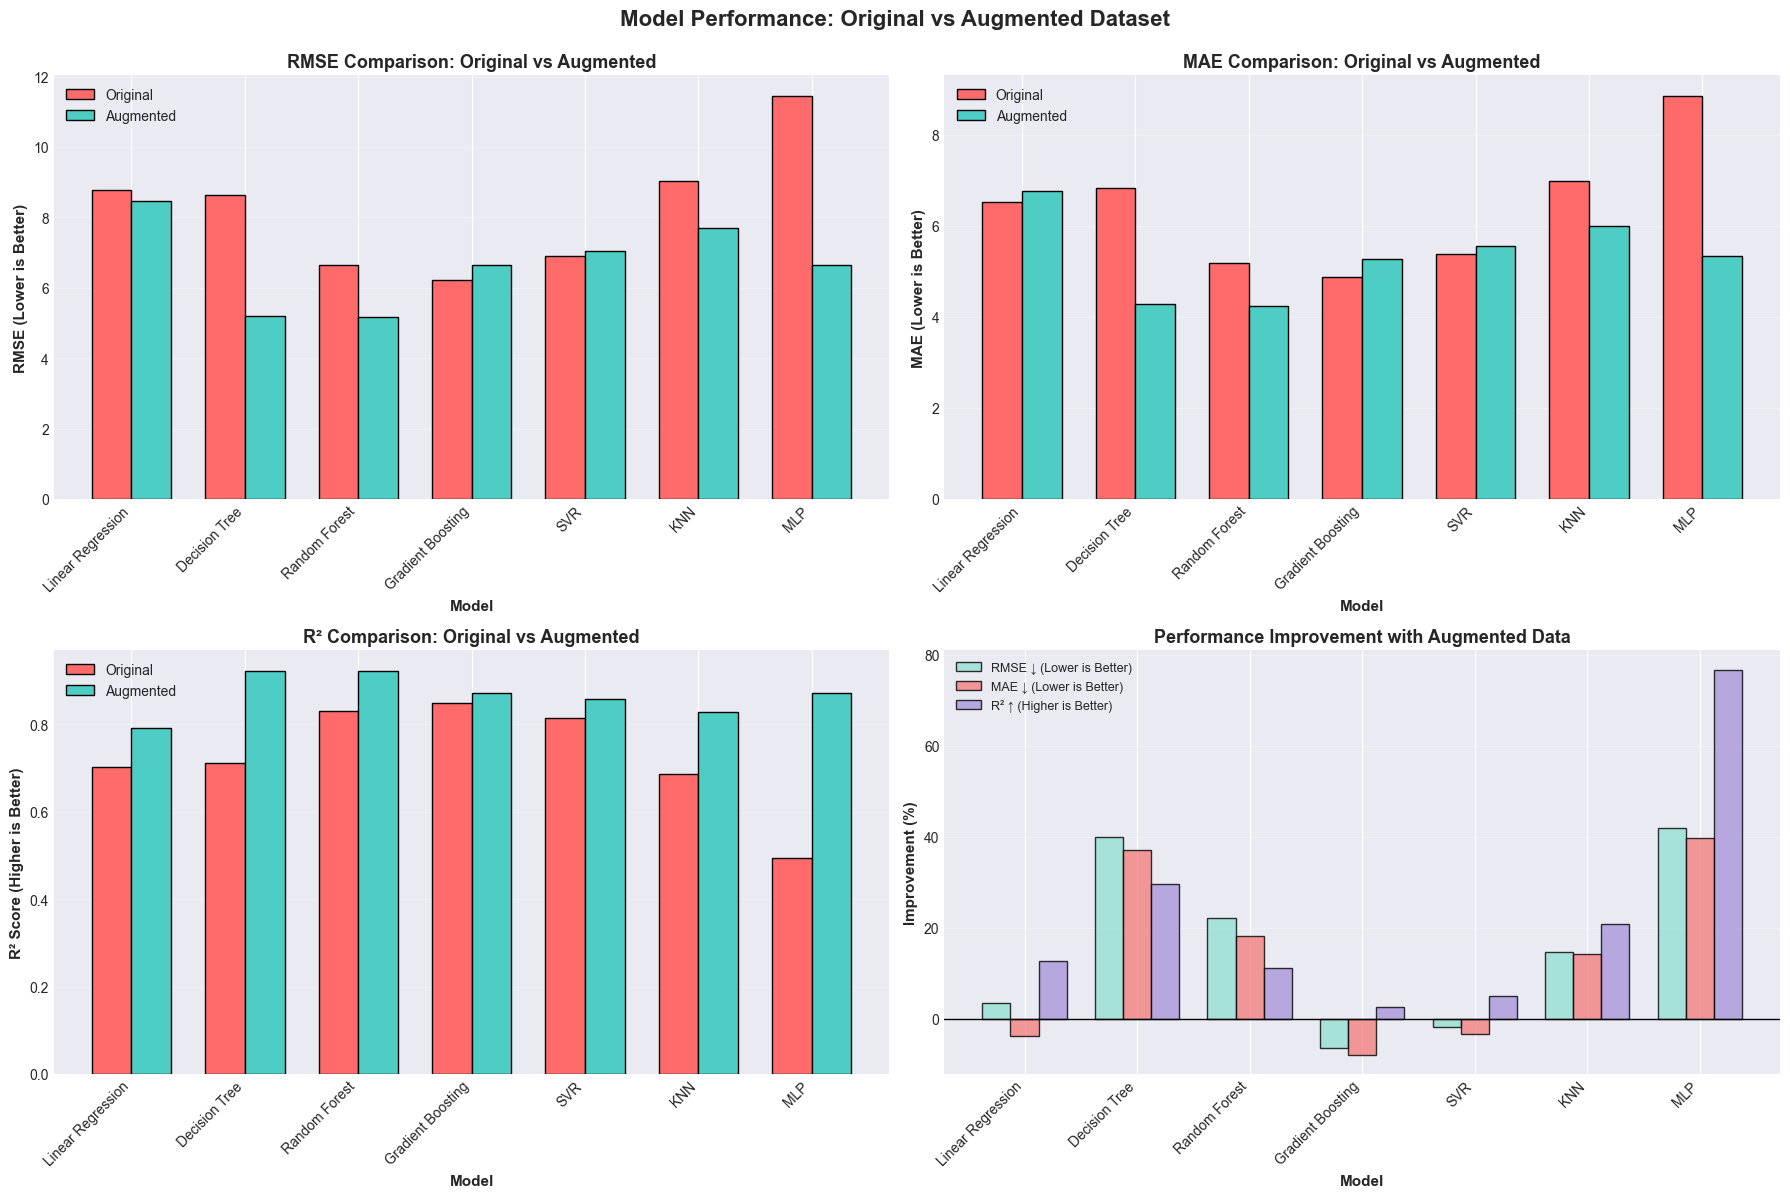


=== Metric Interpretation ===
RMSE (Root Mean Squared Error): Lower values are better - indicates smaller prediction errors
MAE (Mean Absolute Error): Lower values are better - indicates smaller average errors
R² (Coefficient of Determination): Higher values are better - indicates better model fit (0 to 1 scale)

Positive improvement % for RMSE/MAE means error reduction (good)
Positive improvement % for R² means better model fit (good)


In [56]:
# Visualization: Side-by-side comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# RMSE Comparison (Lower is better)
ax = axes[0, 0]
x = np.arange(len(df_comparison))
width = 0.35
bars1 = ax.bar(x - width/2, df_comparison['RMSE_Original'], width, label='Original', color='#FF6B6B', edgecolor='black')
bars2 = ax.bar(x + width/2, df_comparison['RMSE_Augmented'], width, label='Augmented', color='#4ECDC4', edgecolor='black')
ax.set_xlabel('Model', fontweight='bold', fontsize=11)
ax.set_ylabel('RMSE (Lower is Better)', fontweight='bold', fontsize=11)
ax.set_title('RMSE Comparison: Original vs Augmented', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# MAE Comparison (Lower is better)
ax = axes[0, 1]
bars1 = ax.bar(x - width/2, df_comparison['MAE_Original'], width, label='Original', color='#FF6B6B', edgecolor='black')
bars2 = ax.bar(x + width/2, df_comparison['MAE_Augmented'], width, label='Augmented', color='#4ECDC4', edgecolor='black')
ax.set_xlabel('Model', fontweight='bold', fontsize=11)
ax.set_ylabel('MAE (Lower is Better)', fontweight='bold', fontsize=11)
ax.set_title('MAE Comparison: Original vs Augmented', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# R² Comparison (Higher is better)
ax = axes[1, 0]
bars1 = ax.bar(x - width/2, df_comparison['R²_Original'], width, label='Original', color='#FF6B6B', edgecolor='black')
bars2 = ax.bar(x + width/2, df_comparison['R²_Augmented'], width, label='Augmented', color='#4ECDC4', edgecolor='black')
ax.set_xlabel('Model', fontweight='bold', fontsize=11)
ax.set_ylabel('R² Score (Higher is Better)', fontweight='bold', fontsize=11)
ax.set_title('R² Comparison: Original vs Augmented', fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(df_comparison['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Improvement Percentages
ax = axes[1, 1]
improvement_metrics = ['RMSE_Improvement_%', 'MAE_Improvement_%', 'R²_Improvement_%']
improvement_labels = ['RMSE ↓ (Lower is Better)', 'MAE ↓ (Lower is Better)', 'R² ↑ (Higher is Better)']
colors_improvement = ['#95E1D3', '#F38181', '#AA96DA']

x_imp = np.arange(len(df_comparison))
bar_width = 0.25

for i, (metric, label, color) in enumerate(zip(improvement_metrics, improvement_labels, colors_improvement)):
    ax.bar(x_imp + i * bar_width, df_comparison[metric], bar_width,
           label=label, color=color, edgecolor='black', alpha=0.8)

ax.set_xlabel('Model', fontweight='bold', fontsize=11)
ax.set_ylabel('Improvement (%)', fontweight='bold', fontsize=11)
ax.set_title('Performance Improvement with Augmented Data', fontweight='bold', fontsize=13)
ax.set_xticks(x_imp + bar_width)
ax.set_xticklabels(df_comparison['Model'], rotation=45, ha='right')
ax.axhline(0, color='black', linewidth=1, linestyle='-')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Model Performance: Original vs Augmented Dataset', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'model_comparison_original_vs_augmented.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Metric Interpretation ===")
print("RMSE (Root Mean Squared Error): Lower values are better - indicates smaller prediction errors")
print("MAE (Mean Absolute Error): Lower values are better - indicates smaller average errors")
print("R² (Coefficient of Determination): Higher values are better - indicates better model fit (0 to 1 scale)")
print("\nPositive improvement % for RMSE/MAE means error reduction (good)")
print("Positive improvement % for R² means better model fit (good)")

In [57]:
# Summary statistics
print("\n=== Summary Statistics ===\n")

print("Average Improvement Across All Models:")
print(f"  RMSE reduction: {df_comparison['RMSE_Improvement_%'].mean():.2f}%")
print(f"  MAE reduction: {df_comparison['MAE_Improvement_%'].mean():.2f}%")
print(f"  R² increase: {df_comparison['R²_Improvement_%'].mean():.2f}%")

print("\nBest Performing Model (Augmented Dataset):")
best_model_idx = df_comparison['R²_Augmented'].idxmax()
best_model = df_comparison.loc[best_model_idx]
print(f"  Model: {best_model['Model']}")
print(f"  RMSE: {best_model['RMSE_Augmented']:.4f} (vs {best_model['RMSE_Original']:.4f} original)")
print(f"  MAE: {best_model['MAE_Augmented']:.4f} (vs {best_model['MAE_Original']:.4f} original)")
print(f"  R²: {best_model['R²_Augmented']:.4f} (vs {best_model['R²_Original']:.4f} original)")

print("\nMost Improved Model:")
most_improved_idx = df_comparison['R²_Improvement_%'].idxmax()
most_improved = df_comparison.loc[most_improved_idx]
print(f"  Model: {most_improved['Model']}")
print(f"  R² improvement: {most_improved['R²_Improvement_%']:.2f}%")
print(f"  RMSE improvement: {most_improved['RMSE_Improvement_%']:.2f}%")
print(f"  MAE improvement: {most_improved['MAE_Improvement_%']:.2f}%")


=== Summary Statistics ===

Average Improvement Across All Models:
  RMSE reduction: 16.27%
  MAE reduction: 13.46%
  R² increase: 22.71%

Best Performing Model (Augmented Dataset):
  Model: Random Forest
  RMSE: 5.1602 (vs 6.6362 original)
  MAE: 4.2424 (vs 5.1825 original)
  R²: 0.9232 (vs 0.8302 original)

Most Improved Model:
  Model: MLP
  R² improvement: 76.70%
  RMSE improvement: 41.91%
  MAE improvement: 39.66%


# 7. Deep Learning Models for QoE Prediction

## 7.1 AttentionMLP

**AttentionMLP** is a multi-layer perceptron enhanced with an attention mechanism that learns which features are most important for QoE prediction.

#### Architecture Components:
- **Attention Layer**: Learns feature importance weights (input → 128 → input with sigmoid activation)
- **MLP Layers**: 256 → 128 → 64 → 1 neurons with ReLU activation and dropout
- **Feature Weighting**: Attention weights are multiplied with input features before prediction

### Implementation Details:

- **Framework**: PyTorch for custom neural network implementation
- **Training Dataset**: Augmented dataset (2,700 samples with demographic variations)
- **Optimization**: Adam optimizer (learning rate = 0.001)
- **Loss Function**: Mean Squared Error (MSE)
- **Training**: 40 epochs with batch size of 256
- **Regularization**: 20% dropout to prevent overfitting
- **Evaluation Metrics**: RMSE, MAE, R², PLCC, SRCC (consistent with classical ML models)
### 7.1.1 Install Deep Learning Dependencies

Install PyTorch TabNet, a specialized deep learning architecture for tabular data that provides interpretability through attention mechanisms.


In [ ]:
!pip install pytorch-tabnet


### 7.1.2 Import Deep Learning Libraries

Import PyTorch for neural network implementation, TabNet for interpretable deep learning on tabular data, and necessary utilities for data handling and evaluation.


In [59]:
# Import deep learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("="*70)
print("DEEP LEARNING LIBRARIES LOADED")
print("="*70)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print("="*70)


DEEP LEARNING LIBRARIES LOADED
PyTorch version: 2.8.0+cpu
CUDA available: False


### 7.1.3 Data Preparation for Deep Learning

Convert the preprocessed augmented dataset into PyTorch tensors and create DataLoader objects for efficient batch processing during training.

**Key Steps:**
1. Reshape labels to 2D format required by PyTorch
2. Convert NumPy arrays to PyTorch tensors (float32)
3. Create TensorDataset objects combining features and labels
4. Initialize DataLoader with batch size = 256 for mini-batch gradient descent
5. Enable shuffling for training data to prevent overfitting


In [60]:
# Prepare data for deep learning models
print("="*70)
print("PREPARING DATA FOR DEEP LEARNING")
print("="*70)

# Use augmented dataset
X_dl = X_train_aug_scaled
y_dl = y_train_aug.values.reshape(-1, 1)  # Reshape to 2D

X_dl_test = X_test_aug_scaled
y_dl_test = y_test_aug.values.reshape(-1, 1)

print(f"\nTraining data shape: {X_dl.shape}")
print(f"Training labels shape: {y_dl.shape}")
print(f"Test data shape: {X_dl_test.shape}")
print(f"Test labels shape: {y_dl_test.shape}")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_dl, dtype=torch.float32)
y_train_tensor = torch.tensor(y_dl, dtype=torch.float32)
X_test_tensor = torch.tensor(X_dl_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_dl_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
print("="*70)


PREPARING DATA FOR DEEP LEARNING

Training data shape: (2160, 67)
Training labels shape: (2160, 1)
Test data shape: (540, 67)
Test labels shape: (540, 1)

Batch size: 256
Training batches: 9
Test batches: 3


### 7.1.4 AttentionMLP Architecture Definition

Define a custom neural network that combines attention mechanisms with multi-layer perceptrons to learn feature importance automatically.

**Attention Mechanism:**
- Input features pass through attention layer
- Produces weights (0-1) indicating feature importance
- Features are element-wise multiplied by attention weights
- Allows model to focus on most relevant QoE indicators

**MLP Structure:**
- Layer 1: 256 neurons with ReLU and 20% dropout
- Layer 2: 128 neurons with ReLU and 20% dropout  
- Layer 3: 64 neurons with ReLU
- Output: Single neuron for MOS prediction

**Advantages:**
- Automatic feature selection through attention
- Reduces overfitting via dropout regularization
- Non-linear relationships captured through deep architecture


In [61]:
# Define Attention-based MLP Architecture
class AttentionMLP(nn.Module):
    """
    Multi-Layer Perceptron with Attention Mechanism
    
    Architecture:
    - Attention layer: learns feature importance weights
    - MLP layers: 256 -> 128 -> 64 -> 1 with ReLU and Dropout
    """
    def __init__(self, input_dim):
        super().__init__()
        
        # Feature attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            nn.Sigmoid()  # Output attention weights [0, 1]
        )
        
        # Main prediction network
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        # Compute attention weights
        att_weights = self.attention(x)
        # Apply attention to input features
        x_attended = x * att_weights
        # Forward through MLP
        output = self.mlp(x_attended)
        return output

print("="*70)
print("ATTENTION-MLP ARCHITECTURE DEFINED")
print("="*70)
print("\nModel Components:")
print("  1. Attention Layer: 128 hidden units")
print("  2. MLP Layers: 256 -> 128 -> 64 -> 1")
print("  3. Dropout: 0.2 (20%)")
print("  4. Activation: ReLU")
print("="*70)


ATTENTION-MLP ARCHITECTURE DEFINED

Model Components:
  1. Attention Layer: 128 hidden units
  2. MLP Layers: 256 -> 128 -> 64 -> 1
  3. Dropout: 0.2 (20%)
  4. Activation: ReLU


### 7.1.5 Model Training

Train the AttentionMLP model using Adam optimizer with mean squared error loss function.

**Training Configuration:**
- **Optimizer**: Adam (Adaptive Moment Estimation)
  - Learning rate: 0.001
  - Combines benefits of AdaGrad and RMSprop
- **Loss Function**: MSE (Mean Squared Error)
  - Penalizes large prediction errors more heavily
- **Epochs**: 40 iterations over entire training set
- **Batch Size**: 256 samples per gradient update
- **Device**: Automatically selects GPU if available, else CPU

**Training Process:**
1. Forward pass: compute predictions
2. Calculate MSE loss between predictions and ground truth
3. Backward pass: compute gradients via backpropagation
4. Update weights using Adam optimizer
5. Track loss per epoch for convergence monitoring


In [62]:
# Initialize and train AttentionMLP model
print("="*70)
print("TRAINING ATTENTION-MLP MODEL")
print("="*70)

# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {device}")

# Initialize model
model = AttentionMLP(input_dim=X_train_tensor.shape[1]).to(device)
print(f"Input features: {X_train_tensor.shape[1]}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
print(f"\nLoss function: MSE")
print(f"Optimizer: Adam (lr=0.001)")

# Training loop
EPOCHS = 40
train_losses = []

print(f"\nTraining for {EPOCHS} epochs...")
print("-"*70)

for epoch in range(EPOCHS):
    model.train()
    batch_losses = []
    
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    
    epoch_loss = np.mean(batch_losses)
    train_losses.append(epoch_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1:2d}/{EPOCHS}] - Loss: {epoch_loss:.4f}")

print("-"*70)
print(f"Training completed! Final loss: {train_losses[-1]:.4f}")
print("="*70)


TRAINING ATTENTION-MLP MODEL

Using device: cpu
Input features: 67
Model parameters: 75,972

Loss function: MSE
Optimizer: Adam (lr=0.001)

Training for 40 epochs...
----------------------------------------------------------------------
Epoch [ 5/40] - Loss: 922.5104
Epoch [ 5/40] - Loss: 922.5104
Epoch [10/40] - Loss: 208.8401
Epoch [10/40] - Loss: 208.8401
Epoch [15/40] - Loss: 117.3837
Epoch [15/40] - Loss: 117.3837
Epoch [20/40] - Loss: 99.0930
Epoch [20/40] - Loss: 99.0930
Epoch [25/40] - Loss: 87.7114
Epoch [25/40] - Loss: 87.7114
Epoch [30/40] - Loss: 78.9707
Epoch [30/40] - Loss: 78.9707
Epoch [35/40] - Loss: 73.1976
Epoch [35/40] - Loss: 73.1976
Epoch [40/40] - Loss: 70.3633
----------------------------------------------------------------------
Training completed! Final loss: 70.3633
Epoch [40/40] - Loss: 70.3633
----------------------------------------------------------------------
Training completed! Final loss: 70.3633


### 7.1.6 Training Curve Visualization

Plot the training loss curve to analyze model convergence and detect potential issues like overfitting or underfitting.

**Analysis Points:**
- **Steady Decrease**: Indicates successful learning
- **Plateau**: Model has converged to optimal weights
- **Oscillations**: May indicate learning rate too high
- **Early Plateau**: Possible underfitting, consider more complex model


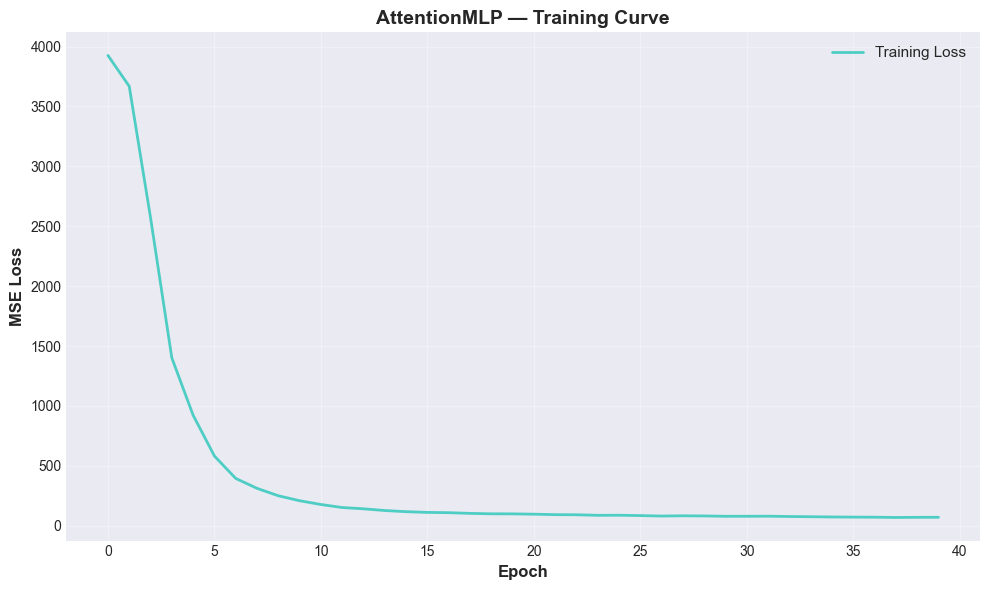

Training curve saved to: data\attentionmlp_training_curve.png


In [63]:
# Plot training curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses, linewidth=2, color='#4ECDC4', label='Training Loss')
plt.xlabel('Epoch', fontsize=12, fontweight='bold')
plt.ylabel('MSE Loss', fontsize=12, fontweight='bold')
plt.title('AttentionMLP — Training Curve', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'attentionmlp_training_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Training curve saved to: {os.path.join(base_path, 'attentionmlp_training_curve.png')}")


### 7.1.7 Model Evaluation on Test Set

Evaluate the trained AttentionMLP model on unseen test data using comprehensive metrics consistent with classical ML evaluation.

**Evaluation Metrics:**
- **RMSE**: Root Mean Squared Error (lower = better)
- **MAE**: Mean Absolute Error (lower = better)
- **R²**: Proportion of variance explained (0-1, higher = better)
- **PLCC**: Pearson Linear Correlation (-1 to 1, measures linear relationship)
- **SRCC**: Spearman Rank Correlation (-1 to 1, measures monotonic relationship)

**Note**: Model is set to evaluation mode (`model.eval()`) to disable dropout and use batch normalization in inference mode.


In [64]:
# Evaluate AttentionMLP on test set
print("="*70)
print("ATTENTION-MLP EVALUATION")
print("="*70)

model.eval()
with torch.no_grad():
    y_pred_dl = model(X_test_tensor.to(device)).cpu().numpy().flatten()

y_dl_test_flat = y_dl_test.flatten()

# Calculate metrics
rmse_att = np.sqrt(mean_squared_error(y_dl_test_flat, y_pred_dl))
mae_att = mean_absolute_error(y_dl_test_flat, y_pred_dl)
r2_att = r2_score(y_dl_test_flat, y_pred_dl)
plcc_att, _ = pearsonr(y_dl_test_flat, y_pred_dl)
srcc_att, _ = spearmanr(y_dl_test_flat, y_pred_dl)

print("\nTest Set Results:")
print(f"  RMSE:  {rmse_att:.4f}")
print(f"  MAE:   {mae_att:.4f}")
print(f"  R²:    {r2_att:.4f}")
print(f"  PLCC:  {plcc_att:.4f}")
print(f"  SRCC:  {srcc_att:.4f}")
print("="*70)

# Store results
att_mlp_results = {
    "Model": "AttentionMLP",
    "RMSE": rmse_att,
    "MAE": mae_att,
    "R²": r2_att,
    "PLCC": plcc_att,
    "SRCC": srcc_att
}


ATTENTION-MLP EVALUATION

Test Set Results:
  RMSE:  7.4616
  MAE:   5.9957
  R²:    0.8395
  PLCC:  0.9166
  SRCC:  0.9034


### 7.1.8 Prediction Accuracy Visualization

Scatter plot comparing predicted MOS scores against ground truth values to visually assess model accuracy.

**Plot Elements:**
- **Scatter Points**: Each point represents one test sample
- **Red Dashed Line**: Perfect prediction line (y = x)
- **Proximity to Line**: Closer points indicate better predictions
- **R² Score**: Displayed in title for quick reference

**Interpretation:**
- Points clustered around diagonal = good predictions
- Systematic deviations = potential bias in model
- High spread = high prediction variance


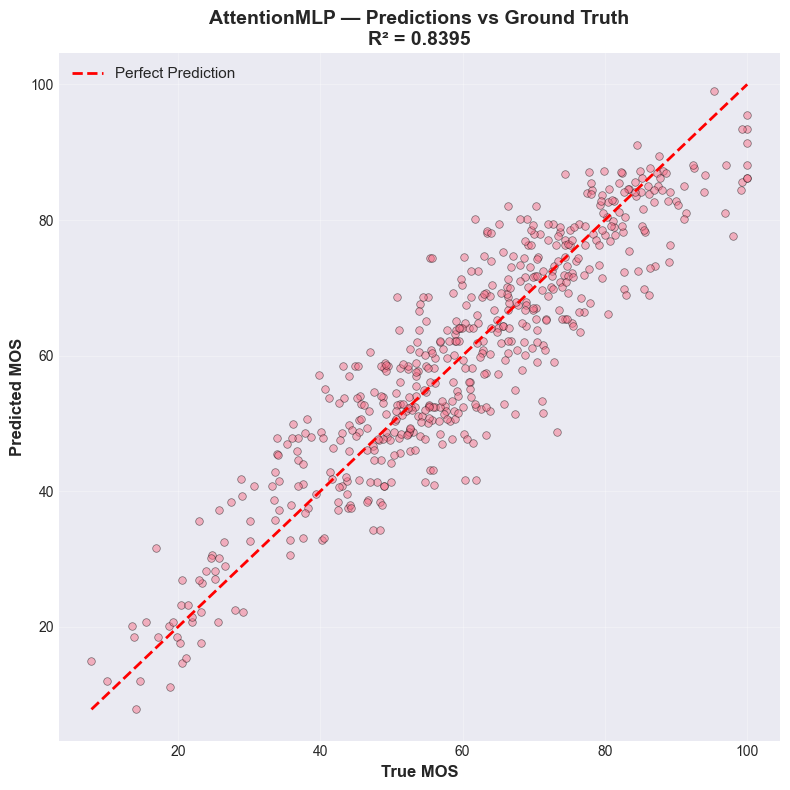

In [65]:
# Predicted vs Actual MOS scatter plot
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(y_dl_test_flat, y_pred_dl, alpha=0.5, s=30, edgecolor='black', linewidth=0.5)

# Perfect prediction line
min_val = min(y_dl_test_flat.min(), y_pred_dl.min())
max_val = max(y_dl_test_flat.max(), y_pred_dl.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('True MOS', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted MOS', fontsize=12, fontweight='bold')
ax.set_title(f'AttentionMLP — Predictions vs Ground Truth\nR² = {r2_att:.4f}', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'attentionmlp_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()


### 7.1.9 Error Distribution and Residual Analysis

Comprehensive error analysis using histogram and residual plots to identify patterns in prediction errors.

**Left Panel - Error Distribution Histogram:**
- Shows frequency of prediction errors
- Centered at zero = unbiased predictions
- Bell-shaped curve = normally distributed errors (good)
- Skewed distribution = systematic bias requiring investigation

**Right Panel - Residual Plot:**
- X-axis: Predicted MOS values
- Y-axis: Residuals (True - Predicted)
- Random scatter around zero = good model fit
- Patterns (e.g., funnel shape) = heteroscedasticity issue
- Trends = non-linear relationships not captured

**Error Statistics:**
- Mean error close to 0 = unbiased model
- Small std error = consistent predictions
- Min/max errors = identify outliers


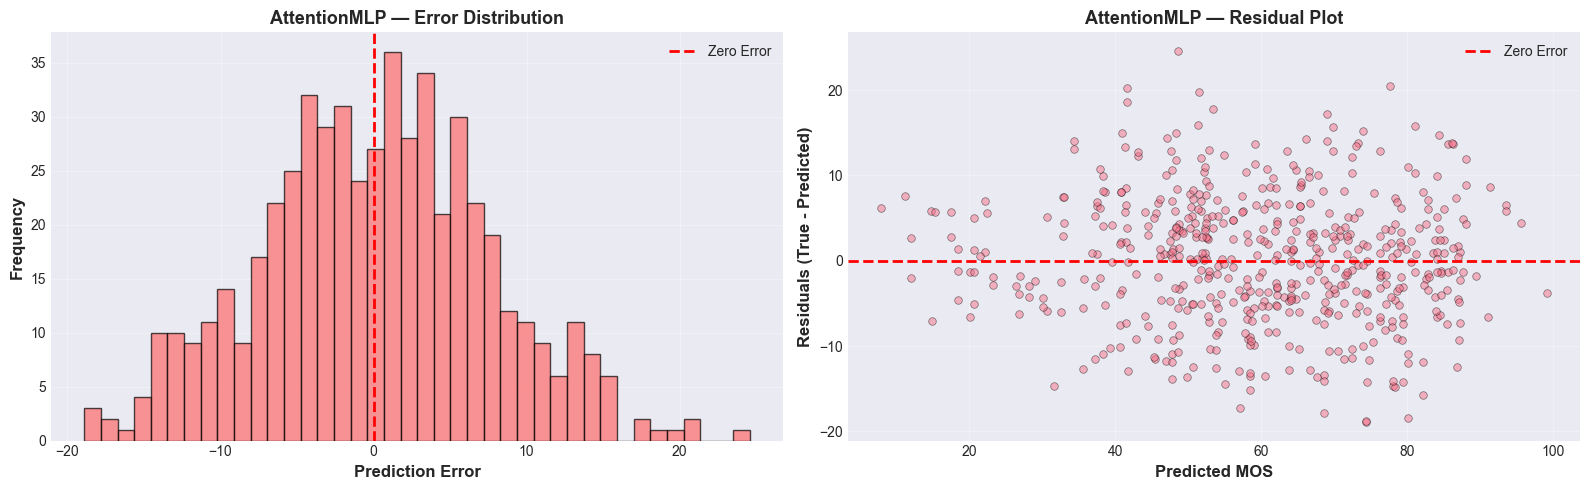


Error Statistics:
  Mean error: 0.1571
  Std error: 7.4599
  Min error: -18.9073
  Max error: 24.6064


In [66]:
# Error distribution analysis
errors = y_dl_test_flat - y_pred_dl

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram of errors
axes[0].hist(errors, bins=40, edgecolor='black', color='#FF6B6B', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_xlabel('Prediction Error', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('AttentionMLP — Error Distribution', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Residual plot
axes[1].scatter(y_pred_dl, errors, alpha=0.5, s=30, edgecolor='black', linewidth=0.5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel('Predicted MOS', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Residuals (True - Predicted)', fontsize=12, fontweight='bold')
axes[1].set_title('AttentionMLP — Residual Plot', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(base_path, 'attentionmlp_error_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nError Statistics:")
print(f"  Mean error: {errors.mean():.4f}")
print(f"  Std error: {errors.std():.4f}")
print(f"  Min error: {errors.min():.4f}")
print(f"  Max error: {errors.max():.4f}")


### 7.1.10 Model Persistence

Save the trained AttentionMLP model weights to disk for future use without retraining.

**Saved Artifacts:**
- Model state dictionary (weights and biases)
- Can be loaded using: `model.load_state_dict(torch.load(path))`
- File format: PyTorch native `.pt` format
- Use case: Deployment, further fine-tuning, or ensemble methods


In [67]:
# Save AttentionMLP model
print("="*70)
print("SAVING DEEP LEARNING MODEL")
print("="*70)

attention_mlp_path = os.path.join(base_path, "attention_mlp_model.pt")
torch.save(model.state_dict(), attention_mlp_path)
print(f"\nAttentionMLP saved: {attention_mlp_path}")


SAVING DEEP LEARNING MODEL

AttentionMLP saved: data\attention_mlp_model.pt


## 7.2 TabNet Model
**TabNet** is a deep learning architecture specifically designed for tabular data. It utilizes sequential attention mechanisms to select relevant features at each decision step, allowing for interpretability and efficient learning.


### 7.2.1 TabNet Training Configuration

TabNet is trained with the following hyperparameters optimized for tabular QoE prediction:

**Training Parameters:**
- **Max Epochs**: 120 (with early stopping)
- **Patience**: 30 epochs without improvement before stopping
- **Batch Size**: 256 samples per batch
- **Virtual Batch Size**: 128 (for ghost batch normalization)
- **Evaluation Sets**: Both train and validation monitored
- **Evaluation Metric**: RMSE

**Key Features:**
- Sequential attention mechanism for feature selection at each decision step
- Built-in interpretability through attention masks
- Ghost batch normalization for better generalization

In [70]:
# Import TabNet
from pytorch_tabnet.tab_model import TabNetRegressor

print("="*70)
print("TRAINING TABNET REGRESSOR")
print("="*70)

# Initialize TabNet
tabnet = TabNetRegressor()

# Train TabNet
print("\nTraining TabNet model...")
tabnet.fit(
    X_train=X_dl,
    y_train=y_dl,
    eval_set=[(X_dl, y_dl), (X_dl_test, y_dl_test)],
    eval_name=['train', 'valid'],
    eval_metric=['rmse'],
    max_epochs=120,
    patience=30,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

print("\nTabNet training complete!")
print("="*70)

# Predictions
print("\nGenerating predictions on test set...")
y_pred_tab = tabnet.predict(X_dl_test).flatten()

# Flatten y_dl_test for correlation metrics
y_dl_test_flat = y_dl_test.flatten()

# Calculate metrics
rmse_t = np.sqrt(mean_squared_error(y_dl_test_flat, y_pred_tab))
mae_t = mean_absolute_error(y_dl_test_flat, y_pred_tab)
r2_t = r2_score(y_dl_test_flat, y_pred_tab)
plcc_t, _ = pearsonr(y_dl_test_flat, y_pred_tab)
srcc_t, _ = spearmanr(y_dl_test_flat, y_pred_tab)

print("\n" + "="*70)
print("TABNET - TEST SET RESULTS")
print("="*70)
print(f"RMSE:  {rmse_t:.4f}")
print(f"MAE:   {mae_t:.4f}")
print(f"R²:    {r2_t:.4f}")
print(f"PLCC:  {plcc_t:.4f}")
print(f"SRCC:  {srcc_t:.4f}")
print("="*70)

# Store results
tabnet_results = {
    "Model": "TabNet",
    "RMSE": rmse_t,
    "MAE": mae_t,
    "R²": r2_t,
    "PLCC": plcc_t,
    "SRCC": srcc_t
}

TRAINING TABNET REGRESSOR

Training TabNet model...
epoch 0  | loss: 3637.46187| train_rmse: 59.00938| valid_rmse: 58.81316|  0:00:01s
epoch 0  | loss: 3637.46187| train_rmse: 59.00938| valid_rmse: 58.81316|  0:00:01s
epoch 1  | loss: 3003.38522| train_rmse: 51.79752| valid_rmse: 51.69133|  0:00:01s
epoch 1  | loss: 3003.38522| train_rmse: 51.79752| valid_rmse: 51.69133|  0:00:01s
epoch 2  | loss: 2183.46379| train_rmse: 38.16373| valid_rmse: 37.67666|  0:00:02s
epoch 2  | loss: 2183.46379| train_rmse: 38.16373| valid_rmse: 37.67666|  0:00:02s
epoch 3  | loss: 1216.43731| train_rmse: 25.75653| valid_rmse: 24.45897|  0:00:02s
epoch 3  | loss: 1216.43731| train_rmse: 25.75653| valid_rmse: 24.45897|  0:00:02s
epoch 4  | loss: 431.38572| train_rmse: 18.33545| valid_rmse: 17.78827|  0:00:03s
epoch 4  | loss: 431.38572| train_rmse: 18.33545| valid_rmse: 17.78827|  0:00:03s
epoch 5  | loss: 180.78539| train_rmse: 18.7065 | valid_rmse: 18.2426 |  0:00:04s
epoch 5  | loss: 180.78539| train_rmse

### 7.2.4 TabNet Model Persistence

Save the trained TabNet model for future deployment and inference without retraining.

**Use Cases:**
- Production deployment for real-time QoE prediction
- Model comparison and ensemble methods
- Transfer learning to related QoE domains

In [71]:
# Save TabNet model
tabnet_path = os.path.join(base_path, "tabnet_model.zip")
tabnet.save_model(tabnet_path)
print(f"TabNet model saved: {tabnet_path}")
print("="*70)

Successfully saved model at data\tabnet_model.zip.zip
TabNet model saved: data\tabnet_model.zip


### 7.2.3 TabNet Error Distribution Analysis

Histogram showing the distribution of prediction errors to assess model bias and consistency.

**Analysis:**
- Distribution centered at zero = unbiased predictions
- Narrow distribution = consistent predictions
- Outliers indicate samples that are difficult to predict accurately

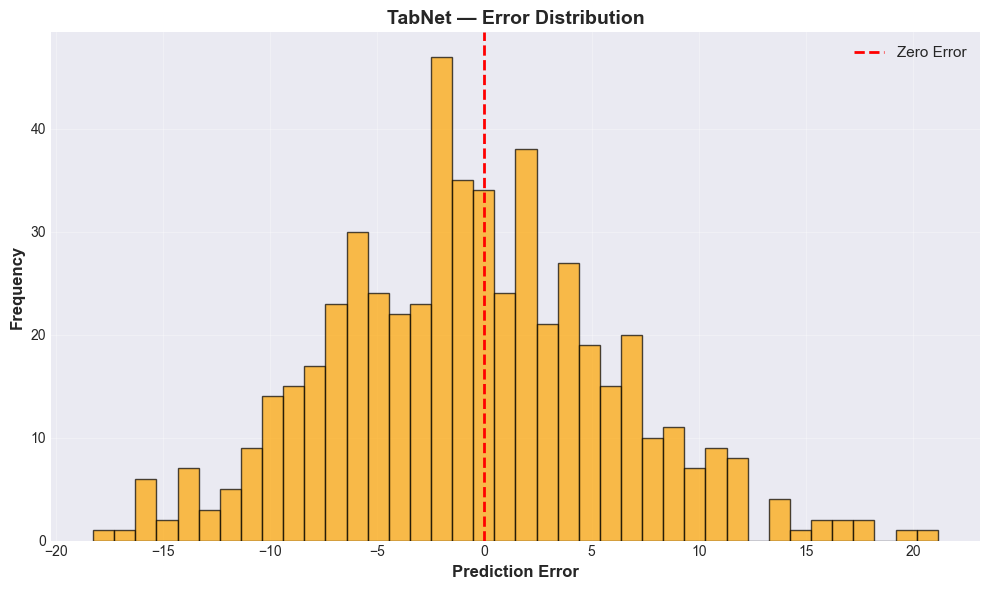


TabNet Error Statistics:
  Mean error: -0.7020
  Std error: 6.5961
  Min error: -18.2650
  Max error: 21.1569


In [72]:
# TabNet error distribution
errors_tab = y_dl_test_flat - y_pred_tab

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(errors_tab, bins=40, edgecolor='black', color='orange', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
ax.set_xlabel('Prediction Error', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('TabNet — Error Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'tabnet_error_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTabNet Error Statistics:")
print(f"  Mean error: {errors_tab.mean():.4f}")
print(f"  Std error: {errors_tab.std():.4f}")
print(f"  Min error: {errors_tab.min():.4f}")
print(f"  Max error: {errors_tab.max():.4f}")

### 7.2.2 TabNet Prediction Visualization

Scatter plot comparing TabNet's predicted MOS scores against ground truth values to visually assess model accuracy.

**Interpretation:**
- Points near the diagonal indicate accurate predictions
- Systematic deviations reveal prediction bias patterns
- Spread indicates prediction variance

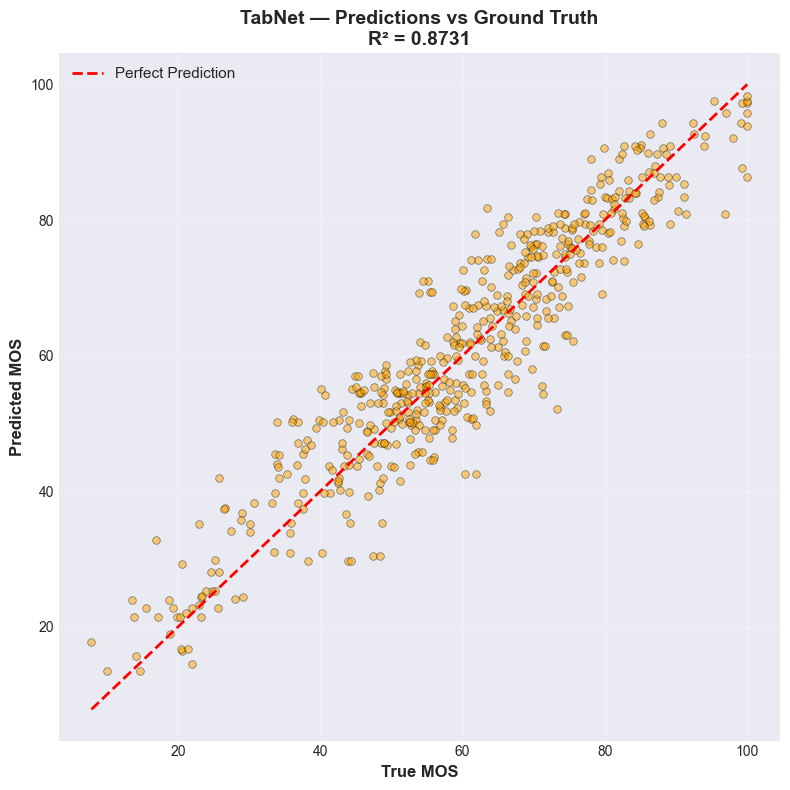

In [73]:
# TabNet: Predicted vs Actual MOS scatter plot
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(y_dl_test_flat, y_pred_tab, alpha=0.5, s=30, edgecolor='black', linewidth=0.5, color='orange')

# Perfect prediction line
min_val = min(y_dl_test_flat.min(), y_pred_tab.min())
max_val = max(y_dl_test_flat.max(), y_pred_tab.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlabel('True MOS', fontsize=12, fontweight='bold')
ax.set_ylabel('Predicted MOS', fontsize=12, fontweight='bold')
ax.set_title(f'TabNet — Predictions vs Ground Truth\nR² = {r2_t:.4f}', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'tabnet_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()

# 8. Comprehensive Model Comparison

## 8.1 Classical ML + Deep Learning Results

Final comparison of all models including classical machine learning algorithms and deep learning architectures.


In [74]:
# Combine classical ML and deep learning results
print("="*70)
print("FINAL MODEL COMPARISON")
print("="*70)

# Create DataFrame for deep learning results
df_dl = pd.DataFrame([att_mlp_results, tabnet_results])

# Combine with classical ML results
df_all_models = pd.concat([df_augmented_results, df_dl], ignore_index=True)

# Save comprehensive results
all_models_path = os.path.join(base_path, "all_models_classical_dl_comparison.csv")
df_all_models.to_csv(all_models_path, index=False)
print(f"\nComprehensive results saved: {all_models_path}")

# Find best model
best_idx = df_all_models['R²'].idxmax()
best_model_overall = df_all_models.loc[best_idx]
print(f"\nBest Overall Model: {best_model_overall['Model']}")
print(f"  R²: {best_model_overall['R²']:.4f}")
print(f"  RMSE: {best_model_overall['RMSE']:.4f}")
print(f"  MAE: {best_model_overall['MAE']:.4f}")

# Display comprehensive model comparison metrics
print("\n" + "="*70)
print("ALL MODELS PERFORMANCE SUMMARY")
print("="*70)
display(df_all_models)
print("="*70)

FINAL MODEL COMPARISON

Comprehensive results saved: data\all_models_classical_dl_comparison.csv

Best Overall Model: Random Forest
  R²: 0.9232
  RMSE: 5.1602
  MAE: 4.2424

ALL MODELS PERFORMANCE SUMMARY


,Model,RMSE,MAE,R²,PLCC,SRCC
0,Linear Regression,8.475335,6.770555,0.792892,0.890756,0.881599
1,Decision Tree,5.201156,4.286942,0.922002,0.960395,0.953441
2,Random Forest,5.160181,4.242410,0.923226,0.961007,0.953755
3,Gradient Boosting,6.638432,5.266049,0.872939,0.935413,0.922628
4,SVR,7.041172,5.558481,0.857054,0.926126,0.913957
5,KNN,7.699008,5.989270,0.829096,0.911420,0.896149
6,MLP,6.656839,5.346392,0.872233,0.934053,0.926273
7,AttentionMLP,7.461580,5.995742,0.839474,0.916613,0.903403
8,TabNet,6.633386,5.246342,0.873132,0.936007,0.927826


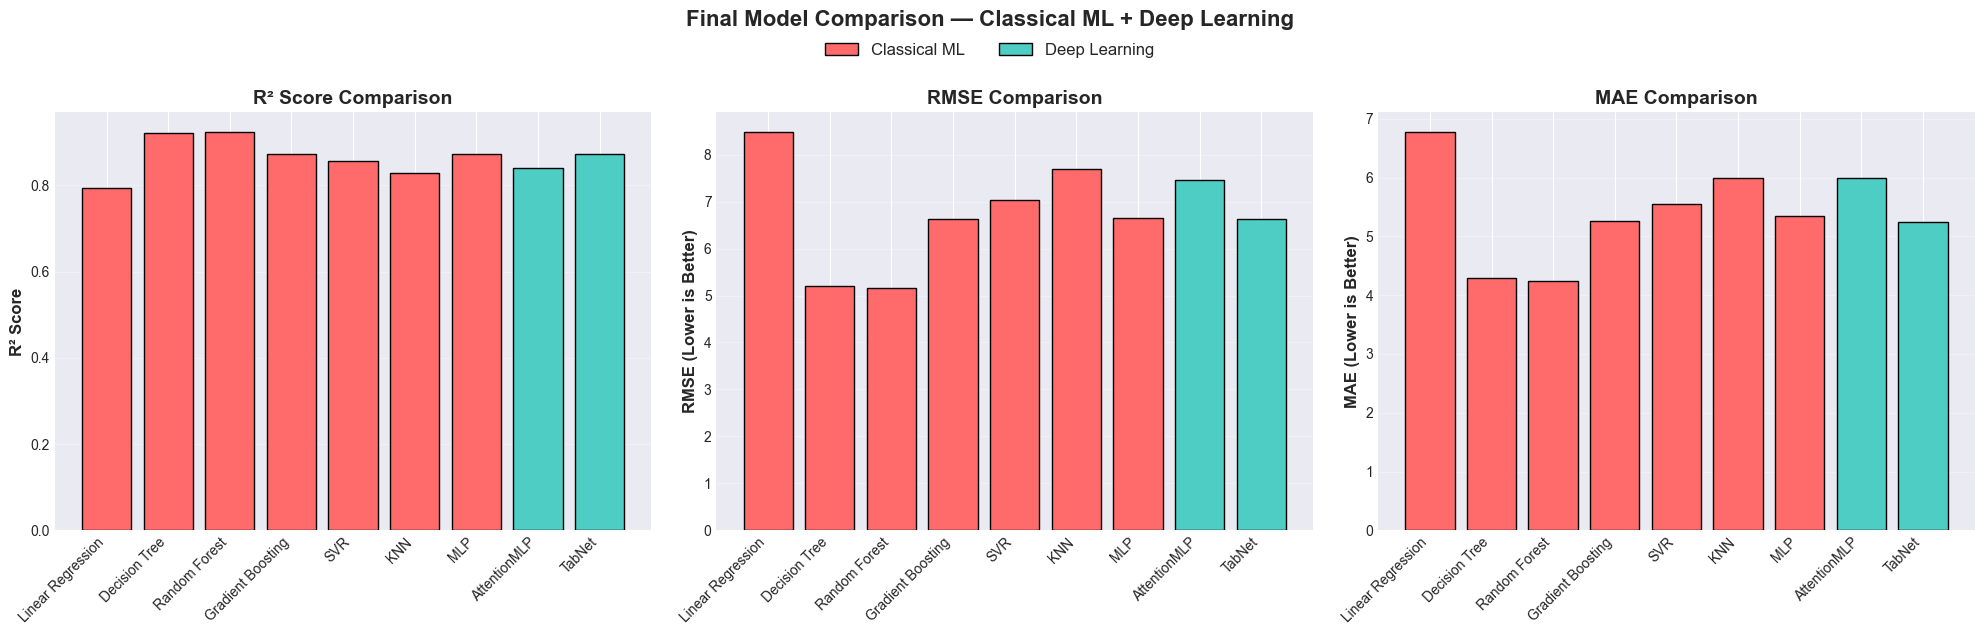

In [75]:
# Final comprehensive comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# R² comparison
ax = axes[0]
colors = ['#FF6B6B' if i < len(df_augmented_results) else '#4ECDC4' 
          for i in range(len(df_all_models))]
bars = ax.bar(df_all_models["Model"], df_all_models["R²"], color=colors, edgecolor='black')
ax.set_ylabel("R² Score", fontsize=12, fontweight='bold')
ax.set_title("R² Score Comparison", fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# RMSE comparison
ax = axes[1]
bars = ax.bar(df_all_models["Model"], df_all_models["RMSE"], color=colors, edgecolor='black')
ax.set_ylabel("RMSE (Lower is Better)", fontsize=12, fontweight='bold')
ax.set_title("RMSE Comparison", fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# MAE comparison
ax = axes[2]
bars = ax.bar(df_all_models["Model"], df_all_models["MAE"], color=colors, edgecolor='black')
ax.set_ylabel("MAE (Lower is Better)", fontsize=12, fontweight='bold')
ax.set_title("MAE Comparison", fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#FF6B6B', edgecolor='black', label='Classical ML'),
    Patch(facecolor='#4ECDC4', edgecolor='black', label='Deep Learning')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=2, 
          fontsize=12, bbox_to_anchor=(0.5, 1.02))

plt.suptitle('Final Model Comparison — Classical ML + Deep Learning', 
             fontsize=16, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig(os.path.join(base_path, 'final_all_models_comparison.png'), 
            dpi=300, bbox_inches='tight')
plt.show()
